# Forest Cover Type Prediction
#### Chris, Dylan, Krista, I-Ching, Riley

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

# show all columns in DF
pd.set_option('display.max_columns', None)

## Introduction

In this notebook, we will explore data obtained from the US Geological Survey and USFS for 30x30 areas.  This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. Using this data, we are to best predict the type of cover that these forests provide, broken into 7 categories: spruce/fir, lodgepole pine, ponderosa pine, cottonwood/willow, aspen, douglas-fir, and krummholz.  

In [2]:
df = pd.read_csv('../data/train.csv', header=0)
df.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0            1  

In [3]:
target_names = ['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', 
                '4 - Cottonwood/Willow', '5 - Aspen', '6 - Douglas-fir',
                '7 - Krummholz']

The first step in dealing with this data will be to clean up the raw data.

In [4]:
# Drop the ID and last column (Cover Type)
data = df.drop(['Id', df.columns[len(df.columns) - 1]], axis=1)
data.shape

(15120, 54)

In [5]:
# Store the cover type in labels
labels = df[df.columns[len(df.columns) - 1]]
labels.shape

(15120,)

In [6]:
for column in data.columns:
    print(data[column].describe(), "\n")

count    15120.000000
mean      2749.322553
std        417.678187
min       1863.000000
25%       2376.000000
50%       2752.000000
75%       3104.000000
max       3849.000000
Name: Elevation, dtype: float64 

count    15120.000000
mean       156.676653
std        110.085801
min          0.000000
25%         65.000000
50%        126.000000
75%        261.000000
max        360.000000
Name: Aspect, dtype: float64 

count    15120.000000
mean        16.501587
std          8.453927
min          0.000000
25%         10.000000
50%         15.000000
75%         22.000000
max         52.000000
Name: Slope, dtype: float64 

count    15120.000000
mean       227.195701
std        210.075296
min          0.000000
25%         67.000000
50%        180.000000
75%        330.000000
max       1343.000000
Name: Horizontal_Distance_To_Hydrology, dtype: float64 

count    15120.000000
mean        51.076521
std         61.239406
min       -146.000000
25%          5.000000
50%         32.000000
75%         

In [7]:
data.groupby(df[df.columns[len(df.columns) - 1]]).size()

# all cover types have an equal number of data points

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

## Helper Functions

In [8]:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.33, random_state=42)
    return X_train, y_train, X_test, y_test

# plot two columns
def my_scatter(col_1, col_2, figsize=(8, 6)):
    fig = plt.figure(figsize=figsize)
    plt.scatter(col_1, col_2, c=labels.values,
                s=50, alpha=.5, cmap='viridis')
    plt.xlabel(col_1.name)
    plt.ylabel(col_2.name)

## Exploratory Data Analysis

Let's take a look at the data that we have.

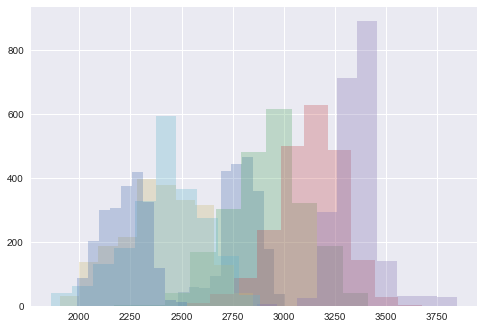

In [9]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for label in labels.unique():
    plt.hist(data.Elevation[labels==label], **kwargs)

Elevation seems to be one of the more binnable for the cover type.  We made a note to focus on this variable.

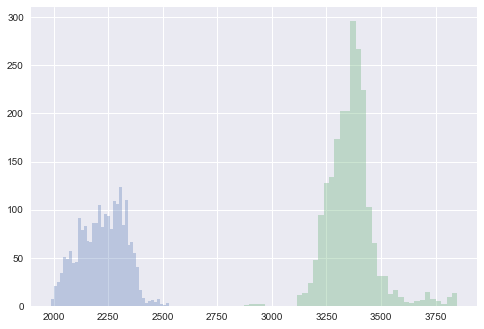

In [10]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)

plt.hist(data.Elevation[labels==4], **kwargs)
plt.hist(data.Elevation[labels==7], **kwargs);

Types 4 and 7 are nicely separated.

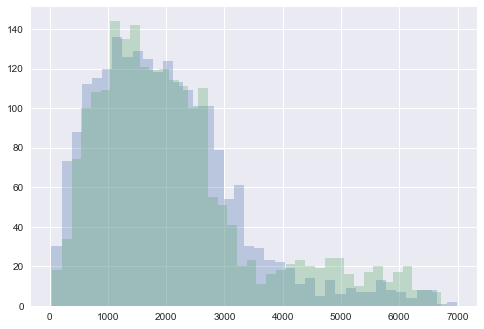

In [11]:
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==1], **kwargs)
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==2], **kwargs);

Types 1 and 2 have a lot of overlap on elevation. This could make them harder to predict.

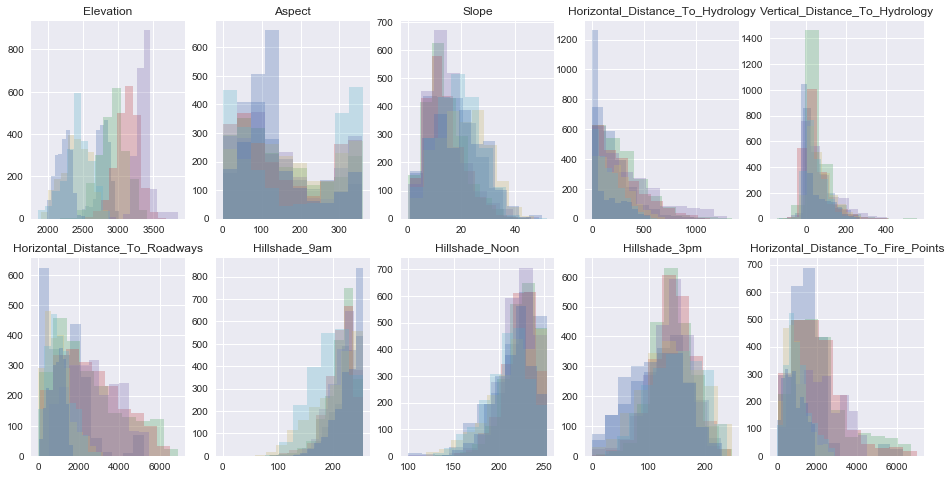

In [12]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in labels.unique():
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

From this, we can see that elevation has the most amount of variability between the different cover types.  Many of the other variables seem to overlap quite a lot for the different cover types, which indicates that they will not be very helpful in differentiating the different cover type.  The other notable features are the Horizontal and Veritcal distances to the disturbances, which have a bit more variation.  

In [13]:
my_columns = [x for x in data.columns.tolist() if "Soil_Type" not in x]
my_columns = [x for x in my_columns if "Wilderness" not in x]
df1 = data.reindex(columns=my_columns)

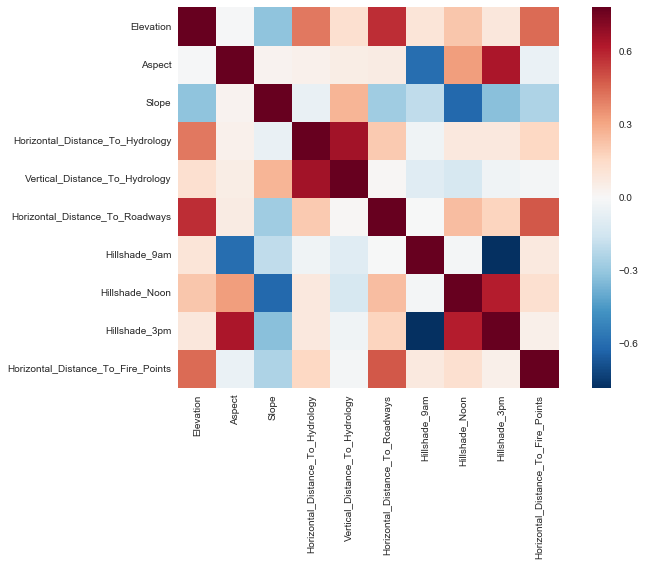

In [14]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corrmat, vmax=.5, square=True);

From this, we can see several things. First, the vertical and horizonal distances are pretty strongly correlated.  Second, the HIllshade_3pm is positively correlated with Hillsahde_noon, and negatively correlated with Hillshade_9am.  We can also see that there is a positive correlation with aspect as well.

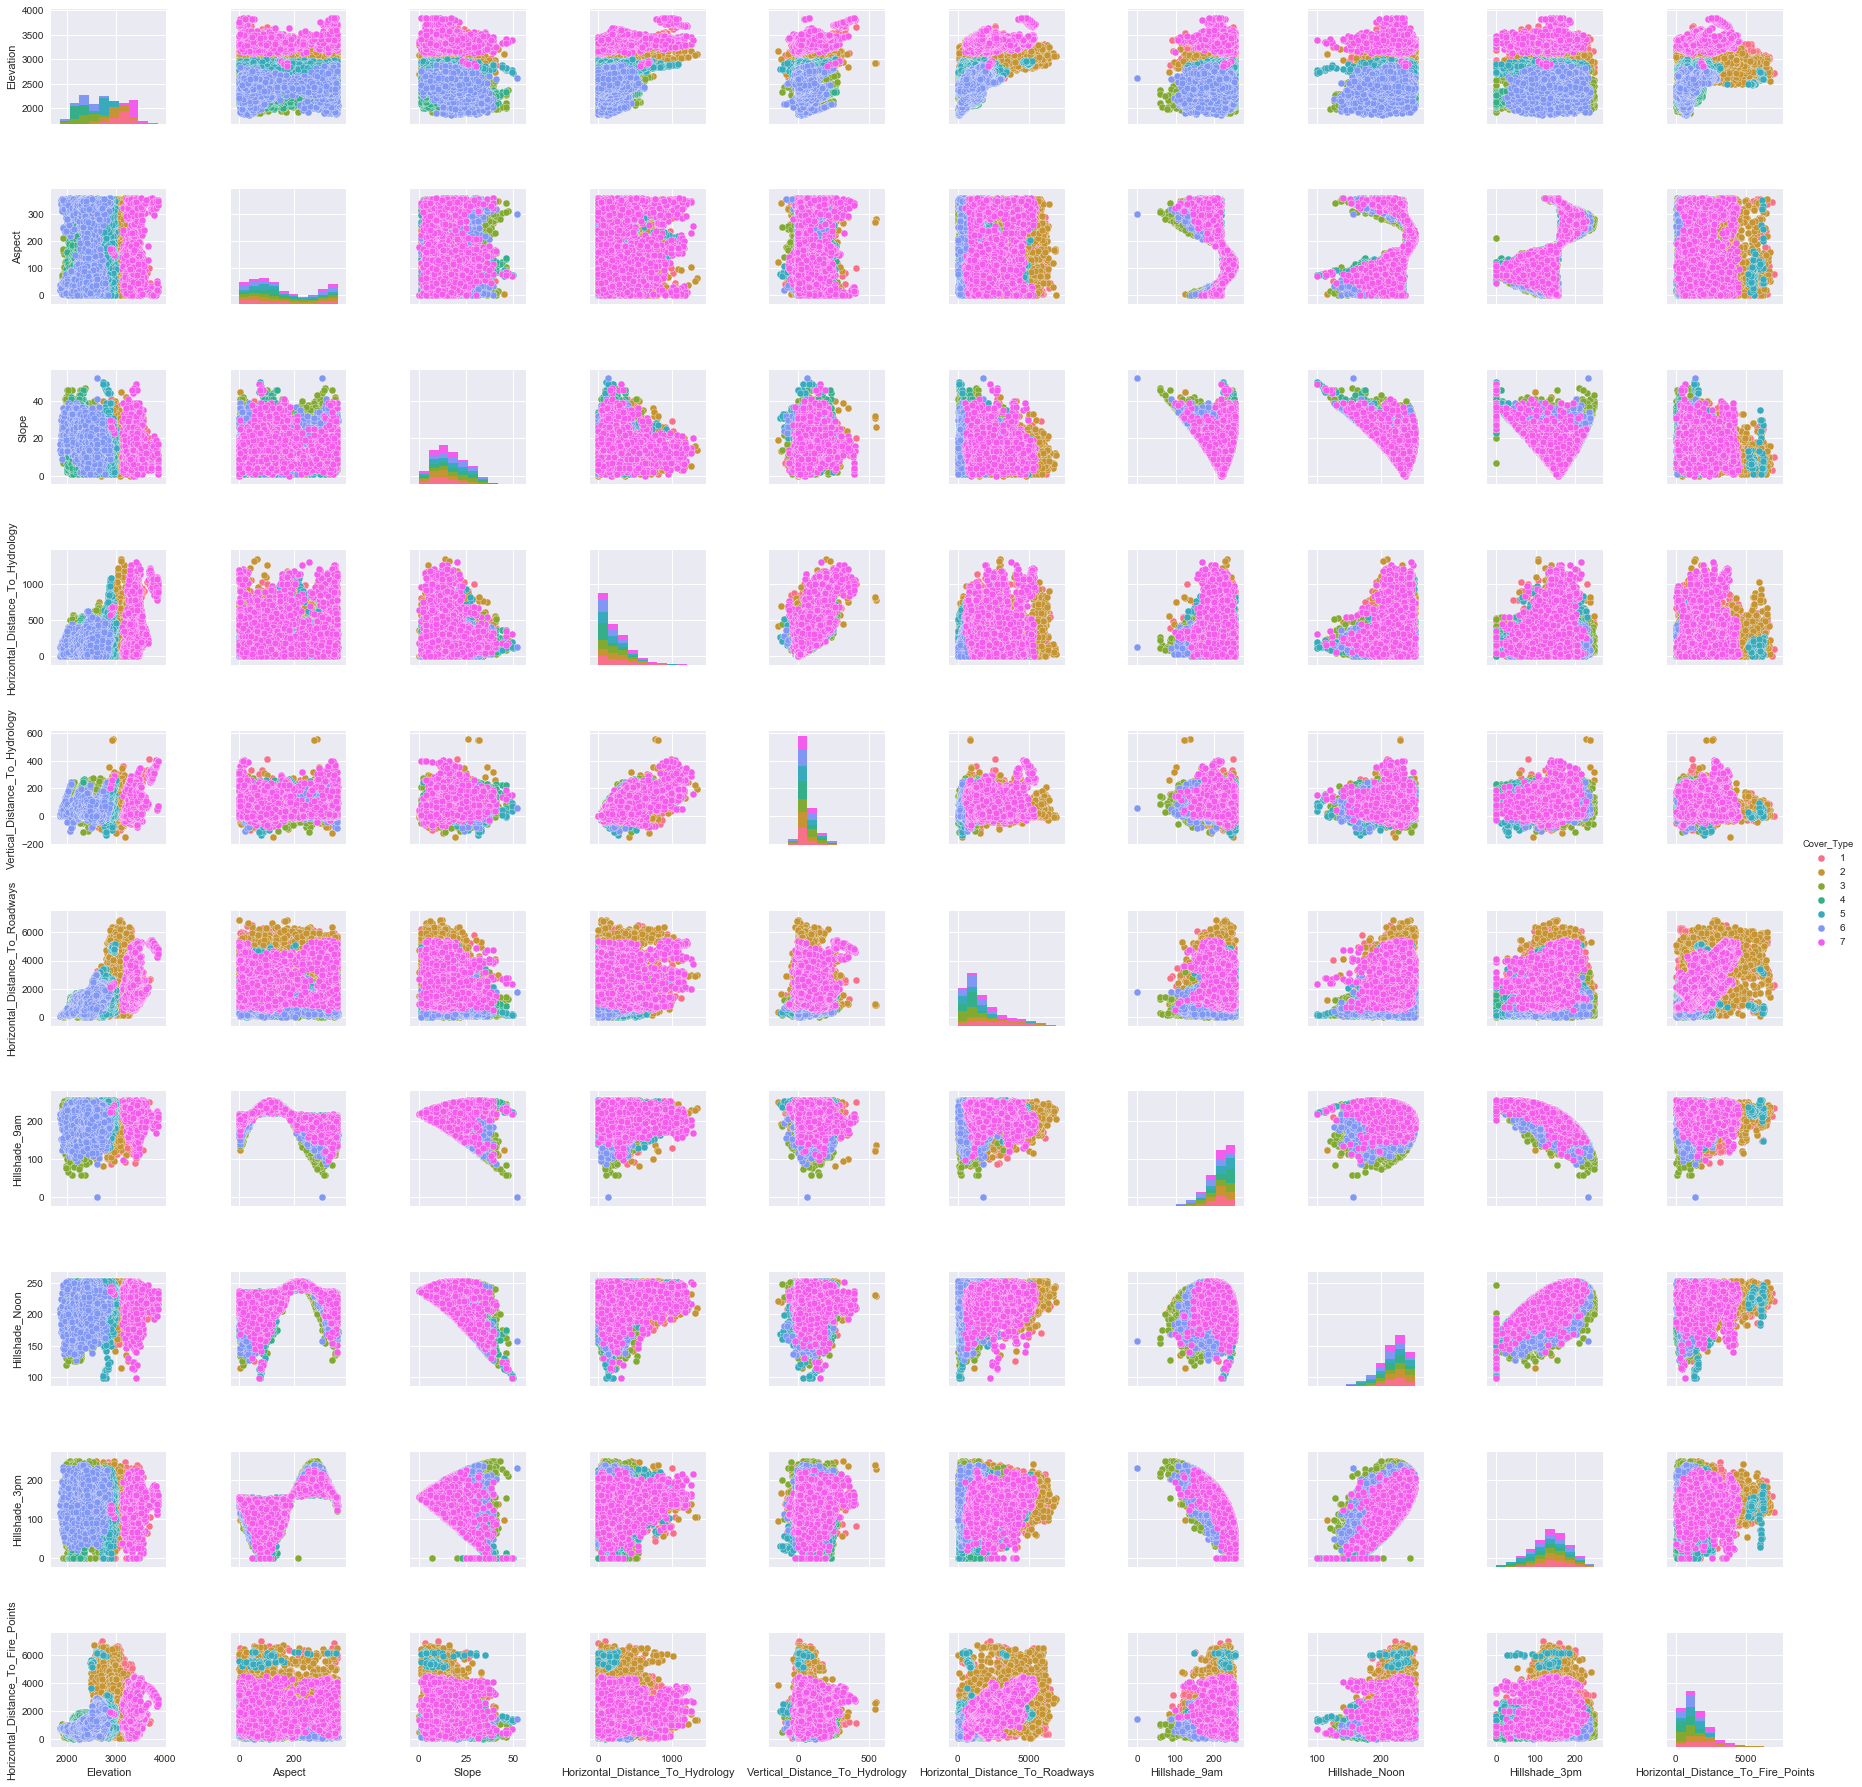

In [15]:
g = sns.pairplot(df, vars=my_columns, hue="Cover_Type")

In [16]:
col_names = df.columns.tolist()
A = np.array(col_names)
soil_types = [item for item in A if "Soil" in item]
for soil_type in soil_types:
    print (soil_type, df[soil_type].sum())

Soil_Type1 355
Soil_Type2 623
Soil_Type3 962
Soil_Type4 843
Soil_Type5 165
Soil_Type6 650
Soil_Type7 0
Soil_Type8 1
Soil_Type9 10
Soil_Type10 2142
Soil_Type11 406
Soil_Type12 227
Soil_Type13 476
Soil_Type14 169
Soil_Type15 0
Soil_Type16 114
Soil_Type17 612
Soil_Type18 60
Soil_Type19 46
Soil_Type20 139
Soil_Type21 16
Soil_Type22 345
Soil_Type23 757
Soil_Type24 257
Soil_Type25 1
Soil_Type26 54
Soil_Type27 15
Soil_Type28 9
Soil_Type29 1291
Soil_Type30 725
Soil_Type31 332
Soil_Type32 690
Soil_Type33 616
Soil_Type34 22
Soil_Type35 102
Soil_Type36 10
Soil_Type37 34
Soil_Type38 728
Soil_Type39 657
Soil_Type40 459


Soil types don't seem to be very consisten, and some soil types have 0 data points, which may need to be dropped.  Overall, we may find that the soil type won't be too helpful.

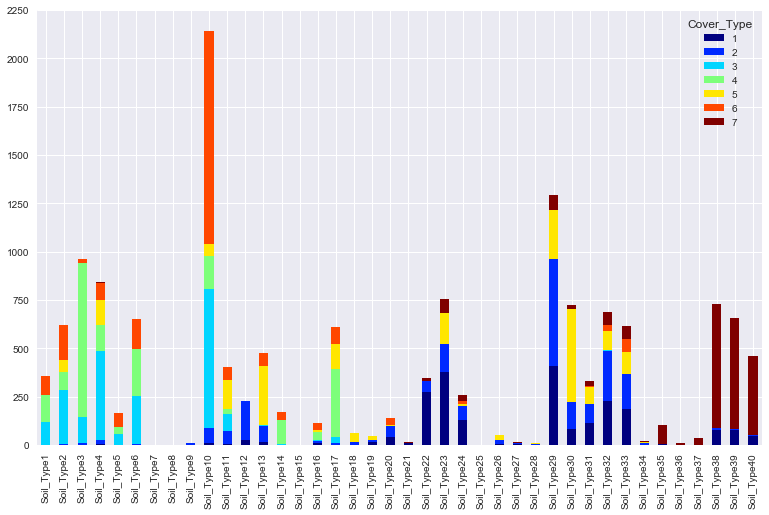

In [17]:
types_sum = df[soil_types].groupby(df['Cover_Type']).sum()
types_sum.T.plot(kind='bar', stacked=True, figsize=(13,8), cmap='jet')

We can see some subtle differences when plotting the cover type that different soils have.  For example, cover type 7 seems to be heavily on the soil types 38,39,40.  In addition, cover type 6 seems to trend towards the lower soil types.  Other points seem to be a bit more scattered.

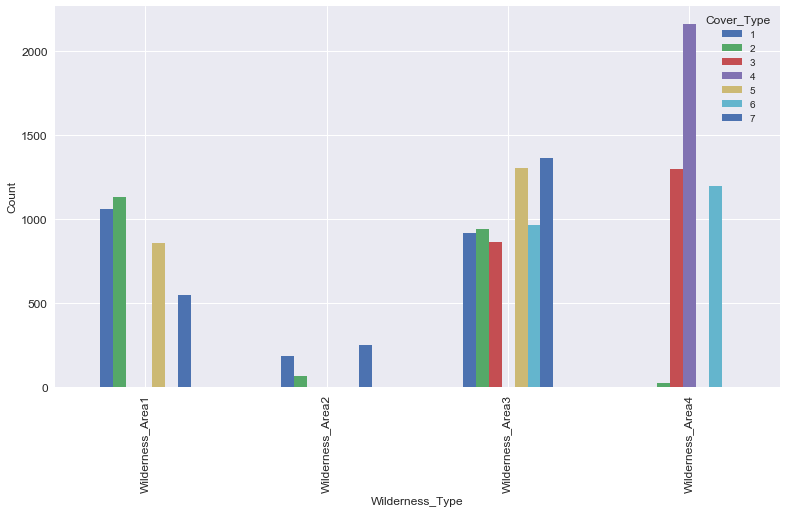

In [18]:
col_names_wilderness = [x for x in df.columns.tolist() if "Wilderness" in x]
types_sum = df[col_names_wilderness].groupby(df['Cover_Type']).sum()
ax = types_sum.T.plot(kind='bar', figsize=(13, 7), legend=True, fontsize=12)
ax.set_xlabel("Wilderness_Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

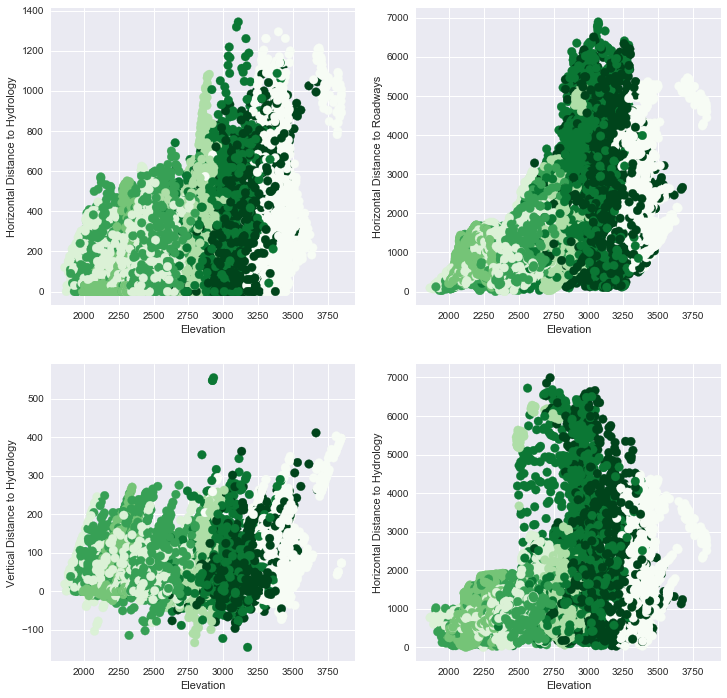

In [19]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology") 

plt.show()

Looking at this, we can see with a small adjustment to the elevation values in relation to the horizontal distance to hydrology, we can get the labels differentiated better.  We try to do this in the next figure.

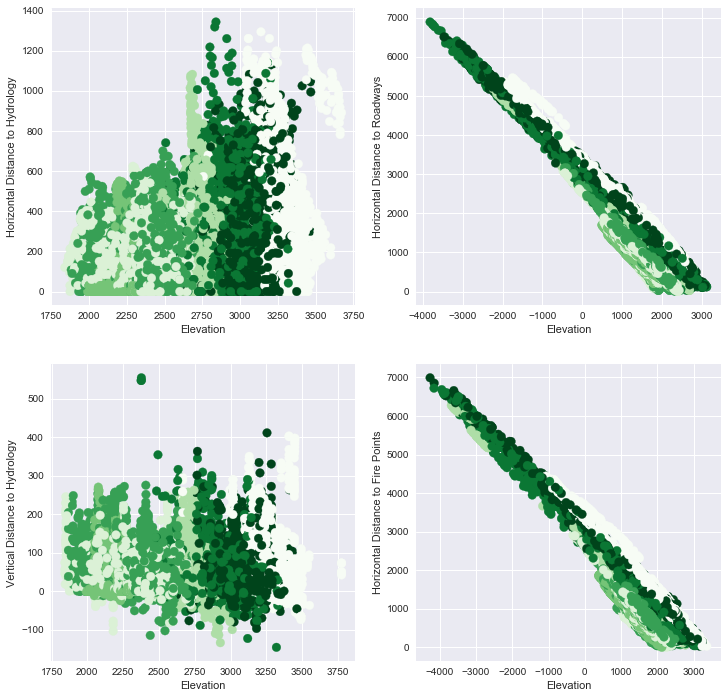

In [20]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation - .2 *df.Horizontal_Distance_To_Hydrology, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Roadways, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation - df.Vertical_Distance_To_Hydrology, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Fire_Points, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Fire Points") 

plt.show()

We can see that the cover types cluster a bit better.  We can see if adjusting this will help with the model.

# Dimensionality Reduction

We'd  like to reduce our feature space to make our modelling simpler, while hopefully preserving the variablility/information in our data.

Below we explore how much variance is explained as we increase the number of PCA components. We found that there was not a logical cut off that allowed us to both reduce the number of features, and preserve variance within the data.

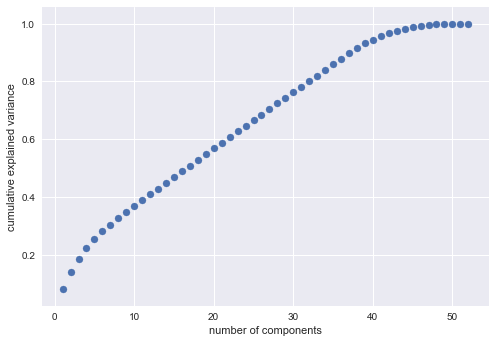

In [22]:
X_train, y_train, X_test, y_test = split_data(data, labels)

X_train_std = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=52)
pca.fit(X_train_std)
plt.scatter(range(1,53),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We'd also like to see if on an extremely simplified case with only 2 PCA components if we could pick find visibly separable data.

In [23]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_std)

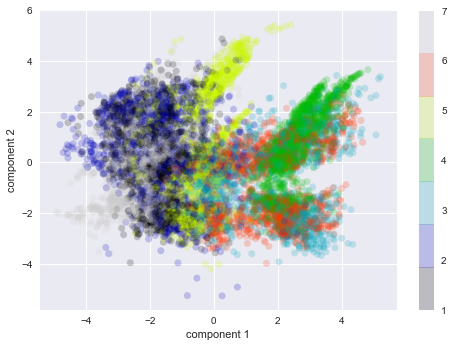

In [24]:
plt.scatter(X_2D[:, 0], X_2D[:, 1],
            c=y_train, edgecolor='none', alpha=0.2,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

After additional attempts, we didn't find strong evidence that PCA was going to help us much. See the the appendix at the end of this notebook for additional trials with PCA

# Feature Selection

In [24]:
# baseline
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

lr_accuracy = np.mean(y_pred == y_test)
lr_accuracy

0.67715430861723447

## Forward selection with Logistic Regression

In [25]:
X_train, y_train, X_test, y_test = split_data(data, labels)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

max_columns = data.shape[1]
column_names = list(data.columns)

max_accuracy = 0
best_features = []
while True:
    best_feature = None
    prev_len = len(best_features)
    
    for column in column_names:
        lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
        test_features = best_features + [column]
        lr_pipe.fit(X_train[test_features], y_train)
        y_pred = lr_pipe.predict(X_test[test_features])

        new_accurancy = np.mean(y_pred == y_test)
        
        if new_accurancy > max_accuracy:
            best_feature = column
            max_accuracy = new_accurancy
    
    if best_feature:
        best_features.append(best_feature)
        column_names.remove(best_feature)
    
    #print(max_accuracy, "\n", best_features)
    
    if len(best_features) == prev_len:
        # no new features added, exit
        break

    
print("Selected {} columns: {}\nAccuracy: {}".format(len(best_features), best_features, max_accuracy))

Selected 19 columns: ['Elevation', 'Soil_Type10', 'Soil_Type22', 'Soil_Type3', 'Soil_Type38', 'Soil_Type39', 'Soil_Type20', 'Wilderness_Area1', 'Soil_Type12', 'Soil_Type40', 'Soil_Type35', 'Soil_Type32', 'Soil_Type31', 'Soil_Type18', 'Soil_Type34', 'Soil_Type37', 'Soil_Type5', 'Soil_Type16', 'Soil_Type28']
Accuracy: 0.6444889779559119


Forward Selection Logistic Regression picked out 19 columns, but still has a low accuracy.

## Ridge Regression to choose features

In [26]:
X_train, y_train, X_test, y_test = split_data(data, labels)

for a in [.01, .05, .1, .5, 1, 2, 10, 20]:
    lr_pipe = make_pipeline(StandardScaler(), RidgeClassifier(alpha=a))
    lr_pipe.fit(X_train, y_train)

    y_pred = lr_pipe.predict(X_test)

    new_accuracy = np.mean(y_pred == y_test)

    coefs = lr_pipe.named_steps['ridgeclassifier'].coef_

    indexes = np.nonzero(coefs == 0)[1]
    zero_features = np.unique(indexes)

    print('Columns to remove:')
    for i in zero_features:
        print(data.columns[i])

    print('Accuracy with Ridge Regression: {}'.format(new_accuracy))

Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6364729458917836
Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6364729458917836
Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6366733466933868
Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6366733466933868
Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6362725450901804
Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6364729458917836
Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6356713426853707
Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6350701402805611


Ridge Regression finds the two soil types with no examples in the training set. Performance is worse with this classifier compared to Linear Regression.

## Random Forest Feature Selection

In [27]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(RandomForestClassifier())
lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)
print('Random Forest accuracy: {}'.format(new_accuracy), '\n')

features = lr_pipe.named_steps['randomforestclassifier'].feature_importances_

features = sorted(zip(features, data.columns), reverse=True)
for f in features:
    print('{:6.4f}, {}'.format(f[0], f[1]))

Random Forest accuracy: 0.8286573146292585 

0.2135, Elevation
0.0854, Horizontal_Distance_To_Roadways
0.0813, Horizontal_Distance_To_Fire_Points
0.0647, Horizontal_Distance_To_Hydrology
0.0544, Vertical_Distance_To_Hydrology
0.0538, Aspect
0.0529, Hillshade_9am
0.0493, Hillshade_3pm
0.0445, Hillshade_Noon
0.0381, Slope
0.0380, Wilderness_Area4
0.0259, Soil_Type38
0.0250, Wilderness_Area3
0.0208, Soil_Type10
0.0162, Wilderness_Area1
0.0158, Soil_Type39
0.0152, Soil_Type40
0.0137, Soil_Type3
0.0106, Soil_Type4
0.0081, Soil_Type30
0.0076, Soil_Type13
0.0061, Soil_Type17
0.0056, Soil_Type23
0.0052, Soil_Type33
0.0050, Soil_Type29
0.0049, Soil_Type2
0.0048, Soil_Type32
0.0044, Soil_Type22
0.0043, Soil_Type11
0.0033, Soil_Type6
0.0028, Wilderness_Area2
0.0027, Soil_Type12
0.0026, Soil_Type31
0.0024, Soil_Type24
0.0016, Soil_Type5
0.0015, Soil_Type1
0.0015, Soil_Type20
0.0013, Soil_Type35
0.0008, Soil_Type14
0.0008, Soil_Type16
0.0007, Soil_Type37
0.0006, Soil_Type26
0.0004, Soil_Type19
0.00

The Random Forest Classifier finds Elevation and Horizontal distance to be the most important features. This classifier performs well and does feature selection.

# Linear Regression Model

In [28]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())

lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

accuracy = np.mean(y_pred == y_test)

The linear regression model does not perform well. We will try it with feature engineering and also see if there are better models.

# Model Selection

For a multiple category classification problem without text data, sklearn's chat suggested that we try KNN, SVM, and ensemble methods. We'll use KNN as our baseline and then try differnt ensemble and SVM methods. After we find the best emsemble and SVM model, we will tune the parameters. 

http://scikit-learn.org/stable/tutorial/machine_learning_map/

SVM are good for high dimensional spaces and is very customizable. They have some nice theoretical guarantees that prevent overfitting and have a simple decision boundary

Ensemble methods combine predictions over several weaker estimators. They are better with multiple categories for classification, but tend to have more complicated decision boundaries and can overfit if not supervised.

In [29]:
X_train, y_train, X_test, y_test = split_data(data, labels)

## Baseline KNN model

In [30]:
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.68      0.63      0.66       679
   2 - Lodgepole Pine       0.67      0.57      0.62       722
   3 - Ponderosa Pine       0.73      0.66      0.69       704
4 - Cottonwood/Willow       0.85      0.96      0.90       739
            5 - Aspen       0.79      0.90      0.84       721
      6 - Douglas-fir       0.71      0.72      0.72       722
        7 - Krummholz       0.91      0.95      0.93       703

          avg / total       0.76      0.77      0.77      4990



## Ensemble methods

We will try a bunch of ensemble methods out of the box.  We'll see if averging methods such as random trees, extra trees workds better by reducing the combined variance of the estimator or if boosting methods, which reduce the bias of the combined estimator are better on our model.  

## Random Forests

In [31]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.70      0.76      0.73       679
   2 - Lodgepole Pine       0.73      0.61      0.66       722
   3 - Ponderosa Pine       0.77      0.81      0.79       704
4 - Cottonwood/Willow       0.92      0.96      0.94       739
            5 - Aspen       0.86      0.91      0.88       721
      6 - Douglas-fir       0.84      0.77      0.81       722
        7 - Krummholz       0.94      0.95      0.94       703

          avg / total       0.82      0.82      0.82      4990



## Extra Trees

In [32]:
model = ExtraTreesClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.70      0.74      0.72       679
   2 - Lodgepole Pine       0.73      0.62      0.67       722
   3 - Ponderosa Pine       0.78      0.79      0.78       704
4 - Cottonwood/Willow       0.91      0.98      0.94       739
            5 - Aspen       0.88      0.91      0.90       721
      6 - Douglas-fir       0.81      0.80      0.80       722
        7 - Krummholz       0.95      0.95      0.95       703

          avg / total       0.82      0.83      0.82      4990



## AdaBoost

In [33]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.63      0.65      0.64       679
   2 - Lodgepole Pine       0.61      0.58      0.60       722
   3 - Ponderosa Pine       0.73      0.72      0.73       704
4 - Cottonwood/Willow       0.93      0.94      0.94       739
            5 - Aspen       0.84      0.85      0.84       721
      6 - Douglas-fir       0.76      0.76      0.76       722
        7 - Krummholz       0.91      0.91      0.91       703

          avg / total       0.77      0.77      0.77      4990



## GradientBoosting

In [34]:
model = GradientBoostingClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.72      0.72      0.72       679
   2 - Lodgepole Pine       0.73      0.58      0.65       722
   3 - Ponderosa Pine       0.75      0.72      0.73       704
4 - Cottonwood/Willow       0.90      0.96      0.93       739
            5 - Aspen       0.80      0.89      0.84       721
      6 - Douglas-fir       0.77      0.77      0.77       722
        7 - Krummholz       0.91      0.95      0.93       703

          avg / total       0.80      0.80      0.80      4990



It looks like averaging methods worked best on our data set.  Extra trees was the best estimaor with an average prevision, recall, and recall of 86%.  This is an improvement over our KNN baseline of 80%. 

## SVM

In [35]:
svm_pipe = make_pipeline(StandardScaler(), SVC())
svm_pipe.fit (X_train, y_train)
y_pred = svm_pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.63      0.68      0.65       679
   2 - Lodgepole Pine       0.65      0.56      0.60       722
   3 - Ponderosa Pine       0.68      0.61      0.64       704
4 - Cottonwood/Willow       0.79      0.96      0.86       739
            5 - Aspen       0.74      0.79      0.77       721
      6 - Douglas-fir       0.68      0.63      0.65       722
        7 - Krummholz       0.91      0.87      0.89       703

          avg / total       0.73      0.73      0.73      4990



# Feature Engineering

After many trials the only feature that we saw significant accuracy benefits from was adding a new variable, which took the mean of all of the horizontal distance metrics to our model. Our intuition around this metric could be simplified down to average distance to "disturbance", if we consider fires, roads, and water sources of potential "disturbance."

In [11]:
## Base Line Random Forest
def base_line_rfc(data):
    X_train, y_train, X_test, y_test = split_data(data, labels)
    lr_pipe = make_pipeline(RandomForestClassifier())
    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    return accuracy

base_rfc_accuracy = base_line_rfc(data)
base_rfc_accuracy

0.81703406813627255

In [12]:
## Base Line Logistic
def base_line_lr(data):
    X_train, y_train, X_test, y_test = split_data(data, labels)

    lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())

    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    return accuracy

base_lr_accuracy = base_line_lr(data)
base_lr_accuracy

0.67715430861723447

In [13]:
def print_base_results(new_data):
    print('Base RFC: {:.4f}, New RFC: {:.4f}'.format(base_rfc_accuracy, base_line_rfc(new_data)))
    print('Base LR:  {:.4f}, New LR:  {:.4f}'.format(base_lr_accuracy, base_line_lr(new_data)))

## Polynomial Features

In [39]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LogisticRegression())
c_vals = [20, 25, 30, 35]
tol = [.01]
penalty = ['l2']
degree = range(2, 3)
param_grid = {
    'polynomialfeatures__degree': degree,
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': penalty,
}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

X_train, y_train, X_test, y_test = split_data(data, labels)

%time grid.fit(X_train, y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
new_accuracy = np.mean(y_pred == y_test)
print('Base LR: {:.4f}, With Polynomials: {:.4f}'.format(base_lr_accuracy, new_accuracy))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.5min finished


CPU times: user 2min 20s, sys: 642 ms, total: 2min 21s
Wall time: 18min 50s
Best params for Logistic Regression: {'logisticregression__C': 20, 'polynomialfeatures__degree': 2, 'logisticregression__penalty': 'l2', 'logisticregression__tol': 0.01}
Base LR: 0.6772, With Polynomials: 0.7860


## Mean Disturbances Feature

In [14]:
def mean_disturb_feat(data):
    new_data = data.copy(deep=True)
    new_data['mean_disturb'] = (new_data.Horizontal_Distance_To_Fire_Points \
                            + new_data.Horizontal_Distance_To_Hydrology \
                            + new_data.Horizontal_Distance_To_Roadways) / 3
    return new_data

In [15]:
new_data = mean_disturb_feat(data)
print_base_results(new_data)

Base RFC: 0.8170, New RFC: 0.8357
Base LR:  0.6772, New LR:  0.6772


## Mean Fire Hydro Feature

In [16]:
def mean_fire_hydro_feat(data):
    new_data = data.copy(deep=True)
    new_data['mean_fire_hydro'] = (new_data.Horizontal_Distance_To_Fire_Points \
                            + new_data.Horizontal_Distance_To_Hydrology) / 2
    return new_data

In [17]:
new_data = mean_fire_hydro_feat(data)
print_base_results(new_data)

Base RFC: 0.8170, New RFC: 0.8327
Base LR:  0.6772, New LR:  0.6772


## Plotting Features

### New elevation feature with Vertical Hydro

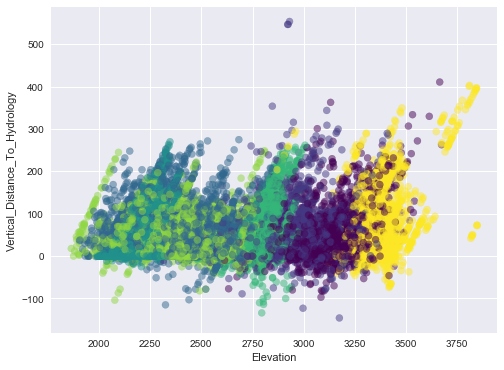

In [18]:
my_scatter(data.Elevation, data.Vertical_Distance_To_Hydrology)

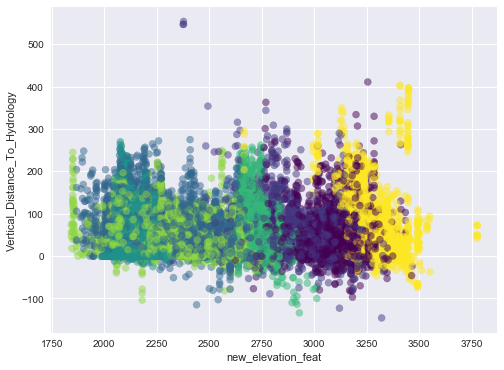

In [19]:
def new_elevation_feat(data):
    new_data = data.copy(deep=True)
    new_feature = new_data.Elevation - new_data.Vertical_Distance_To_Hydrology
    new_data['new_elevation_feat'] = new_feature
    return new_data

new_data = new_elevation_feat(data)
my_scatter(new_data.new_elevation_feat, new_data.Vertical_Distance_To_Hydrology)

In [20]:
print_base_results(new_data)

Base RFC: 0.8170, New RFC: 0.8275
Base LR:  0.6772, New LR:  0.6766


### New Elevation Feature with Horizontal Hydro

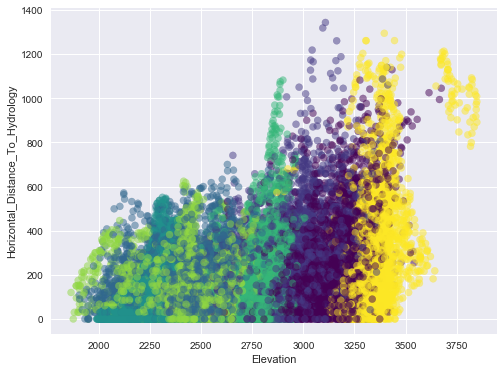

In [21]:
my_scatter(data.Elevation, data.Horizontal_Distance_To_Hydrology)

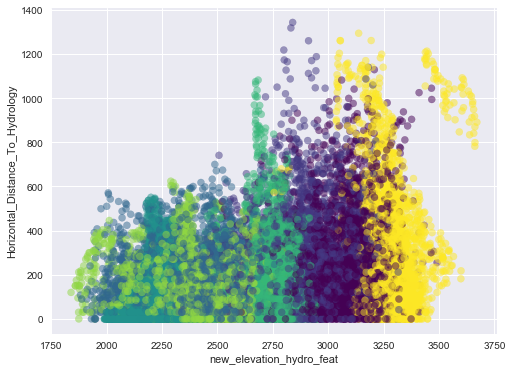

In [22]:
def new_elevation_hydro_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_elevation_hydro_feat'] = new_data.Elevation - new_data.Horizontal_Distance_To_Hydrology * .2
    return new_data

new_data = new_elevation_hydro_feat(data)
my_scatter(new_data.new_elevation_hydro_feat, data.Horizontal_Distance_To_Hydrology)

In [23]:
print_base_results(new_data)

Base RFC: 0.8170, New RFC: 0.8259
Base LR:  0.6772, New LR:  0.6764


### New Elevation Feature adjusted for Fire Points

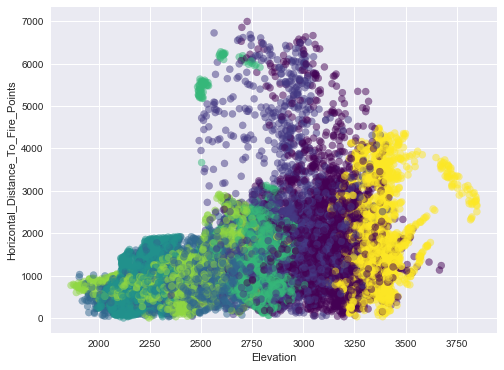

In [24]:
my_scatter(data.Elevation, data.Horizontal_Distance_To_Fire_Points)

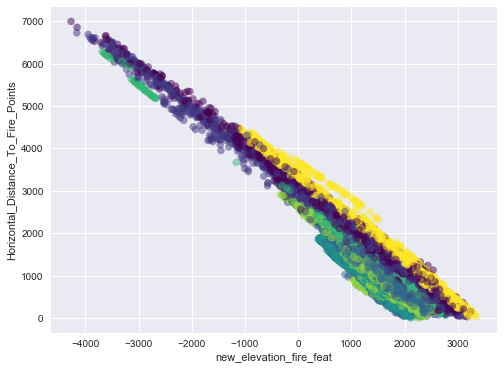

In [25]:
def new_elevation_fire_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_elevation_fire_feat'] = new_data.Elevation - new_data.Horizontal_Distance_To_Fire_Points
    return new_data

new_data = new_elevation_fire_feat(data)
my_scatter(new_data.new_elevation_fire_feat, data.Horizontal_Distance_To_Fire_Points)

In [26]:
print_base_results(new_data)

Base RFC: 0.8170, New RFC: 0.8317
Base LR:  0.6772, New LR:  0.6770


### New Elevation Feature adjusted for Roadways

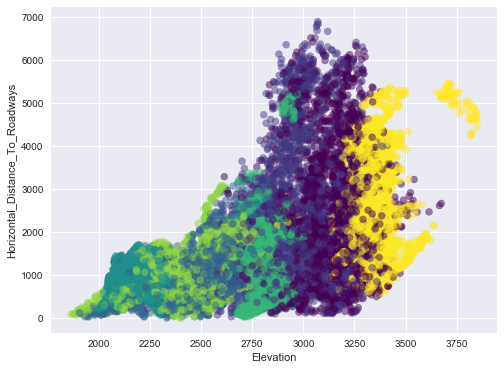

In [27]:
my_scatter(data.Elevation, data.Horizontal_Distance_To_Roadways)

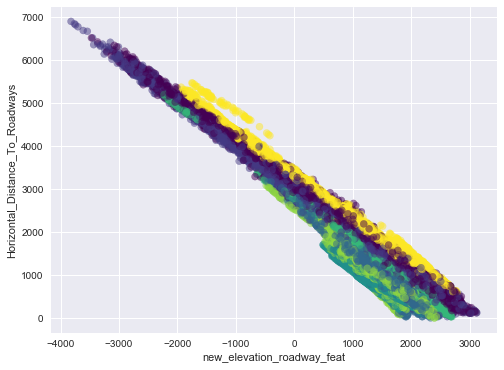

In [28]:
def new_elevation_roadway_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_elevation_roadway_feat'] = new_data.Elevation - new_data.Horizontal_Distance_To_Roadways
    return new_data

new_data = new_elevation_roadway_feat(data)
my_scatter(new_data.new_elevation_roadway_feat, data.Horizontal_Distance_To_Roadways)

In [29]:
print_base_results(new_data)

Base RFC: 0.8170, New RFC: 0.8363
Base LR:  0.6772, New LR:  0.6770


### New Hillshade Feature

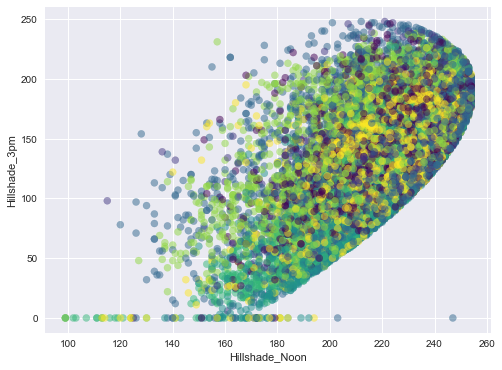

In [30]:
my_scatter(data.Hillshade_Noon, data.Hillshade_3pm)

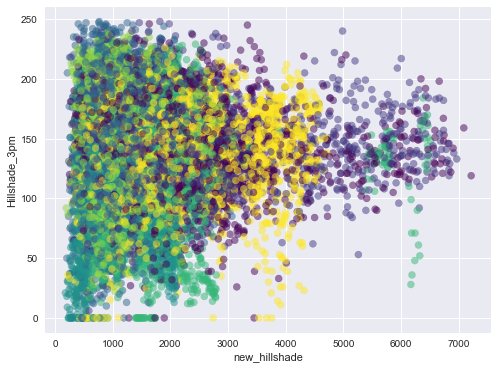

In [31]:
def new_hillshade_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_hillshade'] = new_data.Hillshade_Noon + new_data.Horizontal_Distance_To_Fire_Points
    return new_data

new_data = new_hillshade_feat(data)
my_scatter(new_data.new_hillshade, new_data.Hillshade_3pm)

In [32]:
print_base_results(new_data)

Base RFC: 0.8170, New RFC: 0.8204
Base LR:  0.6772, New LR:  0.6772


### New Hillshade_Hillshade Feature

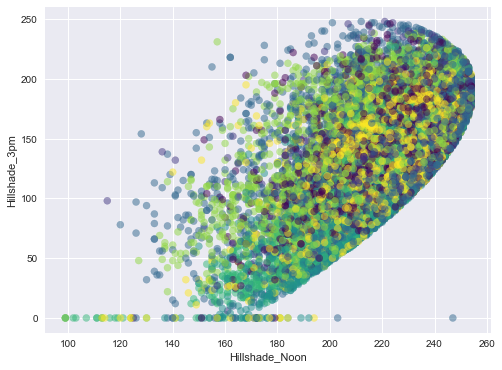

In [33]:
my_scatter(data.Hillshade_Noon, data.Hillshade_3pm)

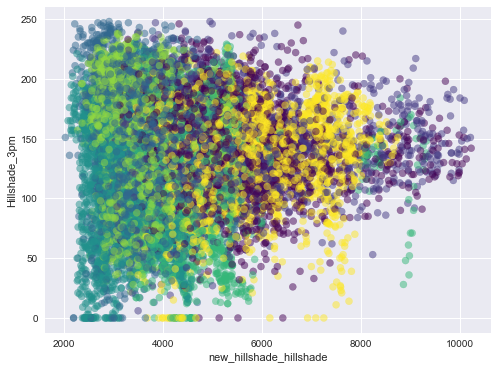

In [34]:
def new_hillshade_hillshade_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_hillshade_hillshade'] = new_data.Hillshade_Noon - new_data.Aspect + \
        new_data.Horizontal_Distance_To_Fire_Points + new_data.Elevation + new_data.Horizontal_Distance_To_Hydrology
    return new_data

new_data = new_hillshade_hillshade_feat(data)
my_scatter(new_data.new_hillshade_hillshade, new_data.Hillshade_3pm)

In [35]:
print_base_results(new_data)

Base RFC: 0.8170, New RFC: 0.8313
Base LR:  0.6772, New LR:  0.6772


# Parameter Tuning With New Features

In [36]:

### Add new features 
def get_new_features_data_rf(data):
    new_feature_funcs = [mean_disturb_feat, mean_fire_hydro_feat, new_elevation_feat,
                         new_elevation_hydro_feat, new_elevation_fire_feat, new_elevation_roadway_feat, new_hillshade_feat,
                         new_hillshade_hillshade_feat]
    new_data = data.copy(deep=True)
    for func in new_feature_funcs:
        new_data = func(new_data)

    return new_data

new_data = get_new_features_data_rf(data)
new_data.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0            1   
2            0        

## Random Forest

In [63]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)

pipe = make_pipeline(RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [500, 1000, 2000], 
    'randomforestclassifier__criterion': ['entropy', 'gini'],
    'randomforestclassifier__max_features': [None, 'auto', 'sqrt', 30],
    'randomforestclassifier__max_depth': [None, 35, 50],
    'randomforestclassifier__bootstrap': [True, False],
}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
%time grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 104.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 189.5min finished


CPU times: user 1min 8s, sys: 3.2 s, total: 1min 11s
Wall time: 3h 10min 22s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__max_features': [None, 'auto', 'sqrt', 30], 'randomforestclassifier__n_estimators': [500, 1000, 2000], 'randomforestclassifier__max_depth': [None, 35, 50], 'randomforestclassifier__bootstrap': [True, False], 'randomforestclassifier__criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [64]:
print(grid.best_params_)
best_rfc = grid.best_estimator_
y_pred = best_rfc.predict(X_test)
print(np.mean(y_pred == y_test))
print(classification_report(y_test, y_pred, target_names=target_names))

{'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 2000, 'randomforestclassifier__max_depth': 35, 'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'gini'}
0.891983967936
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.81      0.81      0.81       679
   2 - Lodgepole Pine       0.82      0.72      0.77       722
   3 - Ponderosa Pine       0.88      0.87      0.88       704
4 - Cottonwood/Willow       0.95      0.98      0.97       739
            5 - Aspen       0.91      0.95      0.93       721
      6 - Douglas-fir       0.90      0.91      0.91       722
        7 - Krummholz       0.95      0.99      0.97       703

          avg / total       0.89      0.89      0.89      4990



In [65]:
# Show importance of new features

features = best_rfc.named_steps['randomforestclassifier'].feature_importances_
features = sorted(zip(features, new_data.columns), reverse=True)

for f in features:
    print('{:6.4f}, {}'.format(f[0], f[1]))

0.1210, new_elevation_hydro_feat
0.1181, new_elevation_feat
0.1117, Elevation
0.0456, mean_disturb
0.0440, Horizontal_Distance_To_Roadways
0.0414, new_hillshade_hillshade
0.0409, new_elevation_roadway_feat
0.0388, Horizontal_Distance_To_Hydrology
0.0328, Hillshade_9am
0.0324, new_elevation_fire_feat
0.0322, Vertical_Distance_To_Hydrology
0.0312, mean_fire_hydro
0.0301, Aspect
0.0288, new_hillshade
0.0280, Horizontal_Distance_To_Fire_Points
0.0269, Hillshade_Noon
0.0262, Hillshade_3pm
0.0220, Wilderness_Area4
0.0192, Slope
0.0165, Soil_Type10
0.0128, Wilderness_Area1
0.0124, Soil_Type3
0.0113, Wilderness_Area3
0.0099, Soil_Type38
0.0087, Soil_Type39
0.0080, Soil_Type4
0.0046, Soil_Type30
0.0042, Soil_Type40
0.0036, Soil_Type17
0.0033, Soil_Type2
0.0032, Soil_Type22
0.0032, Soil_Type32
0.0031, Soil_Type29
0.0027, Soil_Type23
0.0026, Soil_Type12
0.0025, Soil_Type33
0.0023, Soil_Type13
0.0019, Soil_Type6
0.0019, Wilderness_Area2
0.0016, Soil_Type11
0.0013, Soil_Type24
0.0012, Soil_Type20
0

## SVM

In [66]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)
svm_pipe = make_pipeline(StandardScaler(), SVC())

param_grid = {
    'svc__kernel': ['linear', 'rbf'],  
    'svc__C': [50, 100, 200], 
    'svc__gamma': [.01, .05, .1]
} 
grid = GridSearchCV(svm_pipe, param_grid, cv=5, n_jobs=-1)
%time grid.fit(X_train, y_train)

CPU times: user 5.26 s, sys: 418 ms, total: 5.68 s
Wall time: 12min 15s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svc__gamma': [0.01, 0.05, 0.1], 'svc__kernel': ['linear', 'rbf'], 'svc__C': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [67]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

{'svc__gamma': 0.05, 'svc__kernel': 'rbf', 'svc__C': 50}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.75      0.73      0.74       679
   2 - Lodgepole Pine       0.75      0.68      0.71       722
   3 - Ponderosa Pine       0.83      0.78      0.80       704
4 - Cottonwood/Willow       0.92      0.96      0.94       739
            5 - Aspen       0.88      0.93      0.90       721
      6 - Douglas-fir       0.83      0.86      0.85       722
        7 - Krummholz       0.94      0.97      0.96       703

          avg / total       0.84      0.85      0.84      4990



With parameter tuning, we were able to get the accuracy up for SVM too.

# Error analysis

Helper Functions

In [42]:
def create_confusion_matrix(y_test, y_pred, title='Confusion matrix, without normalization'):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title=title)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

In [43]:
#rfc = best_rfc.get_params()['randomforestclassifier']
# {'randomforestclassifier__max_features': 'auto', 
# 'randomforestclassifier__n_estimators': 2000, 'randomforestclassifier__max_depth': 35, 
# 'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'gini'}
rfc = RandomForestClassifier(max_features='auto', n_estimators=2000,
                             max_depth=35, bootstrap=False, criterion='gini', n_jobs=-1)

In [44]:
new_data = get_new_features_data_rf(data)
X_train, y_train, X_test, y_test = split_data(new_data, labels)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(np.mean(y_pred == y_test))

0.892184368737


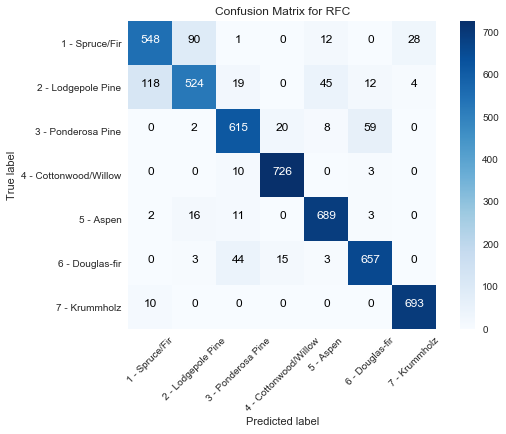

In [45]:
create_confusion_matrix(y_test, y_pred, title="Confusion Matrix for RFC")

It looks like there's some confusion concerning classes 1 & 2 as well as classes 3 & 6. Let's see if there's any data that might shed some light on why these pairs exist, and how we might get around the confusion.

In [46]:
# look at the biggest errors:
# get the probabilites for each example
probs = rfc.predict_proba(X_test)

# get the max probability for each example
max_probs = np.max(probs, axis=1)

# get the probs of the true label
true_label_probs = probs[np.arange(len(probs)), y_test-1]

r_ratio = max_probs / true_label_probs

# get the indexes for the top 3 R ratio
indexes = np.argpartition(r_ratio, -3)[-3:]

for index in indexes:
    print('\n============\n')
    print(index)
    print(X_test.iloc[index], '\n')
    print('True label:', y_test.iloc[index])
    print('Predicated label:', y_pred[index])
    print('Probability of labels: {}'.format(probs[index]))



4355
Elevation                             2353.000000
Aspect                                  61.000000
Slope                                   18.000000
Horizontal_Distance_To_Hydrology        42.000000
Vertical_Distance_To_Hydrology           7.000000
Horizontal_Distance_To_Roadways        430.000000
Hillshade_9am                          232.000000
Hillshade_Noon                         199.000000
Hillshade_3pm                           93.000000
Horizontal_Distance_To_Fire_Points     537.000000
Wilderness_Area1                         0.000000
Wilderness_Area2                         0.000000
Wilderness_Area3                         1.000000
Wilderness_Area4                         0.000000
Soil_Type1                               0.000000
Soil_Type2                               0.000000
Soil_Type3                               0.000000
Soil_Type4                               0.000000
Soil_Type5                               0.000000
Soil_Type6                               0.

### Cover Type 1 General Errors

In [47]:
# look at errors with cover type 1 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 1) & (y_test == 1)
X_errors = X_errors[error_msk]
X_errors.head(10)

true  pred  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
2119      1     2       2900     127     11                                30   
1086      1     2       2960      84     10                                30   
9295      1     7       3263     143     19                               180   
1022      1     2       3049     268     18                               537   
6786      1     5       2712     213     18                                67   
9804      1     2       2819     319     25                               120   
14677     1     2       3019      44     19                               752   
11903     1     7       3309      14      7                               390   
286       1     7       3201     331      5                                 0   
11724     1     7       3314      50      4                               573   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
2119                               -1                             1384   
1086                                5                             3660   
9295                               39                             2873   
1022                              112                             6001   
6786                               14                              918   
9804                               48                              600   
14677                             124                             1282   
11903                              81                             3900   
286                                 0                             4002   
11724                              53                             3586   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
2119             239             232            122   
1086             234             224            121   
9295             243             233            110   
1022             172             244            210   
6786             201             254            183   
9804             148             208            196   
14677            221             196            103   
11903            213             225            149   
286              208             234            164   
11724            222             231            145   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
2119                                 2524                 0                 0   
1086                                 2579                 1                 0   
9295                                 3032                 0                 0   
1022                                 1660                 1                 0   
6786                                 1922                 0                 0   
9804                                 1033                 0                 0   
14677                                1945                 0                 0   
11903                                1410                 1                 0   
286                                  3460                 1                 0   
11724                                4036                 1                 0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
2119                  1                 0           0           0           0   
1086                  0                 0           0           0           0   
9295                  1                 0           0           0           0   
1022                  0                 0           0           0           0   
6786                  1                 0           0           0           0   
9804                  1                 0           0           0           0   
14677                 1                 0           0           0           0   
11903                 0                 0           0           0           0   
286                   0                 0           0           0        

In [48]:
# Describe the accurate predictions
true_msk = (y_pred == 1) & (y_test == 1)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   548.000000  548.000000  548.000000                        548.000000   
mean   3156.428832  160.118613   12.757299                        281.094891   
std     129.546616  117.844468    6.572993                        226.567290   
min    2739.000000    0.000000    1.000000                          0.000000   
25%    3068.750000   51.000000    8.000000                        108.000000   
50%    3163.000000  125.000000   12.000000                        223.000000   
75%    3242.250000  290.000000   16.000000                        410.500000   
max    3666.000000  359.000000   38.000000                       1041.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      548.000000                       548.000000   
mean                        42.198905                      2589.215328   
std                         58.656957                      1497.386661   
min                        -81.000000                       150.000000   
25%                          3.000000                      1399.500000   
50%                         23.500000                      2401.500000   
75%                         58.250000                      3612.250000   
max                        411.000000                      6300.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     548.000000      548.000000     548.000000   
mean      211.684307      224.104015     145.352190   
std        24.161945       17.645248      35.302066   
min       104.000000      152.000000      25.000000   
25%       200.000000      214.000000     123.000000   
50%       216.000000      226.500000     146.000000   
75%       228.000000      237.000000     168.000000   
max       254.000000      254.000000     234.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          548.000000        548.000000        548.000000   
mean                          1950.647810          0.487226          0.104015   
std                           1299.092091          0.500293          0.305558   
min                             42.000000          0.000000          0.000000   
25%                            962.750000          0.000000          0.000000   
50%                           1690.000000          0.000000          0.000000   
75%                           2708.000000          1.000000          0.000000   
max                           6632.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        548.000000             548.0       548.0       548.0       548.0   
mean           0.408759               0.0         0.0         0.0         0.0   
std            0.492054               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       548.0       548.0       548.0       548.0       548.0       548.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0

In [49]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   131.00000  131.000000  131.000000                        131.000000   
mean   3000.29771  156.450382   12.679389                        264.564885   
std     215.10719  110.805735    6.522467                        265.741375   
min    2579.00000    1.000000    2.000000                          0.000000   
25%    2856.00000   62.000000    7.500000                         67.000000   
50%    2947.00000  113.000000   12.000000                        180.000000   
75%    3127.50000  255.500000   17.000000                        380.500000   
max    3487.00000  359.000000   34.000000                       1129.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      131.000000                       131.000000   
mean                        44.633588                      2405.572519   
std                         62.244580                      1588.809564   
min                        -80.000000                       134.000000   
25%                          6.500000                      1081.000000   
50%                         22.000000                      2072.000000   
75%                         59.500000                      3544.000000   
max                        301.000000                      6001.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     131.000000      131.000000     131.000000   
mean      215.534351      223.908397     140.343511   
std        22.670312       18.169480      35.915664   
min       147.000000      162.000000       0.000000   
25%       204.000000      214.000000     116.500000   
50%       219.000000      226.000000     141.000000   
75%       232.000000      237.000000     166.500000   
max       254.000000      254.000000     216.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          131.000000        131.000000        131.000000   
mean                          2147.068702          0.465649          0.045802   
std                           1334.714958          0.500733          0.209857   
min                            124.000000          0.000000          0.000000   
25%                           1255.000000          0.000000          0.000000   
50%                           1920.000000          0.000000          0.000000   
75%                           2583.500000          1.000000          0.000000   
max                           6993.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        131.000000             131.0       131.0       131.0       131.0   
mean           0.488550               0.0         0.0         0.0         0.0   
std            0.501788               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  131.000000       131.0       131.0       131.0       131.0  131.000000   
mean     0.030534         0.0         0.0         0.0         0.0    0.007634   
std      0.172713         0.0         0.0         0.0         0.0    0.087370   
min      0.000000         0.0         0.0         0.0         0.0    0.000000   
25%      0.000000         0.0         0.0         0.0         0.0    0.000000   
50%      0.000000         0.0         0.0         0.0         0.0    0.000000   
75%      0.000000         0.0         0.0         0.0         0.0    0.000000   
max      1.000000        

We can see that the erors have a lower mean elevation. Their vertical distance is a little higher and distance to roadways is also lower.

### Cover Type 1 Predicted 2 Errors

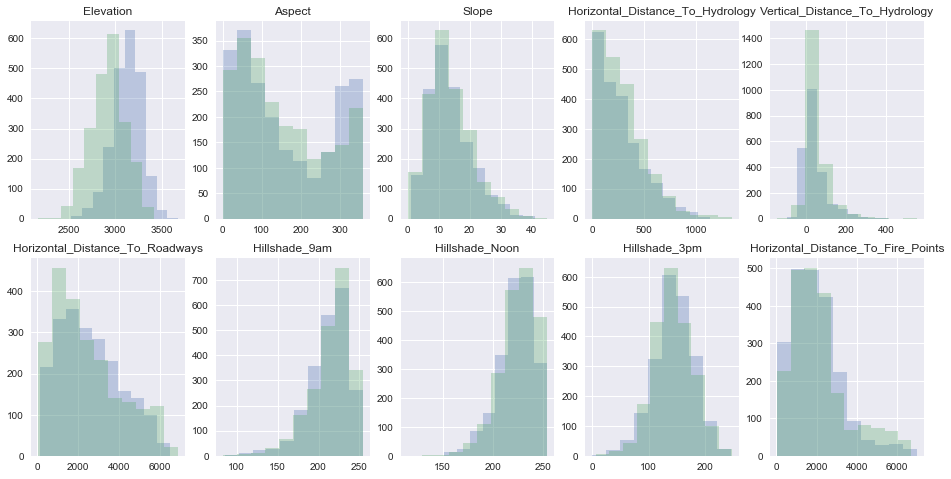

In [50]:
#Display the data between classes 1 and 2
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [1, 2]:
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

Well that explains a lot. These classes are nearly identical. Let's dig a bit deeper though and see look specifically at the 1s that were mistaken for 2s.

In [51]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 2) & (y_test == 1)
X_errors = X_errors[error_msk]

In [52]:
# Describe the accurate predictions
true_msk = (y_pred == 1) & (y_test == 1)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   548.000000  548.000000  548.000000                        548.000000   
mean   3156.428832  160.118613   12.757299                        281.094891   
std     129.546616  117.844468    6.572993                        226.567290   
min    2739.000000    0.000000    1.000000                          0.000000   
25%    3068.750000   51.000000    8.000000                        108.000000   
50%    3163.000000  125.000000   12.000000                        223.000000   
75%    3242.250000  290.000000   16.000000                        410.500000   
max    3666.000000  359.000000   38.000000                       1041.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      548.000000                       548.000000   
mean                        42.198905                      2589.215328   
std                         58.656957                      1497.386661   
min                        -81.000000                       150.000000   
25%                          3.000000                      1399.500000   
50%                         23.500000                      2401.500000   
75%                         58.250000                      3612.250000   
max                        411.000000                      6300.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     548.000000      548.000000     548.000000   
mean      211.684307      224.104015     145.352190   
std        24.161945       17.645248      35.302066   
min       104.000000      152.000000      25.000000   
25%       200.000000      214.000000     123.000000   
50%       216.000000      226.500000     146.000000   
75%       228.000000      237.000000     168.000000   
max       254.000000      254.000000     234.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          548.000000        548.000000        548.000000   
mean                          1950.647810          0.487226          0.104015   
std                           1299.092091          0.500293          0.305558   
min                             42.000000          0.000000          0.000000   
25%                            962.750000          0.000000          0.000000   
50%                           1690.000000          0.000000          0.000000   
75%                           2708.000000          1.000000          0.000000   
max                           6632.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        548.000000             548.0       548.0       548.0       548.0   
mean           0.408759               0.0         0.0         0.0         0.0   
std            0.492054               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       548.0       548.0       548.0       548.0       548.0       548.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0

In [53]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    90.000000   90.000000  90.000000                         90.000000   
mean   2928.933333  144.077778  12.977778                        233.844444   
std     116.480967  110.716992   6.158903                        216.622693   
min    2579.000000    1.000000   2.000000                          0.000000   
25%    2859.250000   57.250000   8.000000                         67.000000   
50%    2936.000000  106.000000  12.000000                        166.000000   
75%    2990.750000  256.000000  16.750000                        345.000000   
max    3215.000000  356.000000  34.000000                        900.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       90.000000                        90.000000   
mean                        40.777778                      2573.766667   
std                         56.219629                      1747.515990   
min                        -80.000000                       134.000000   
25%                          7.000000                      1082.000000   
50%                         21.000000                      2235.000000   
75%                         58.000000                      3917.750000   
max                        301.000000                      6001.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      90.000000       90.000000      90.000000   
mean      216.733333      221.688889     136.611111   
std        23.858572       16.787933      37.869585   
min       147.000000      162.000000       0.000000   
25%       204.250000      214.000000     113.250000   
50%       223.000000      225.000000     134.000000   
75%       233.000000      232.000000     158.750000   
max       254.000000      251.000000     216.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           90.000000         90.000000              90.0   
mean                          2297.600000          0.555556               0.0   
std                           1498.365273          0.499688               0.0   
min                            124.000000          0.000000               0.0   
25%                           1237.750000          0.000000               0.0   
50%                           1940.000000          1.000000               0.0   
75%                           2938.250000          1.000000               0.0   
max                           6993.000000          1.000000               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         90.000000              90.0        90.0        90.0        90.0   
mean           0.444444               0.0         0.0         0.0         0.0   
std            0.499688               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count        90.0        90.0        90.0        90.0        90.0   90.000000   
mean          0.0         0.0         0.0         0.0         0.0    0.011111   
std           0.0         0.0         0.0         0.0         0.0    0.105409   
min           0.0         0.0         0.0         0.0         0.0    0.000000   
25%           0.0         0.0         0.0         0.0         0.0    0.000000   
50%           0.0         0.0         0.0         0.0         0.0    0.000000   
75%           0.0         0.0         0.0         0.0         0.0    0.000000   
max           0.0         

It appears that the mean Horizontal_Distance_To_Fire_Points was about 1.14x the distance from the accurately predicted class 1s. That really seems to be the most glaring disparity here. 

Median elevations: True: 3163.000000, Error: 2936.000000, (92.823269%)
Median distance to fire: True: 1690.000000, Error: 1940.000000, (114.792899%)


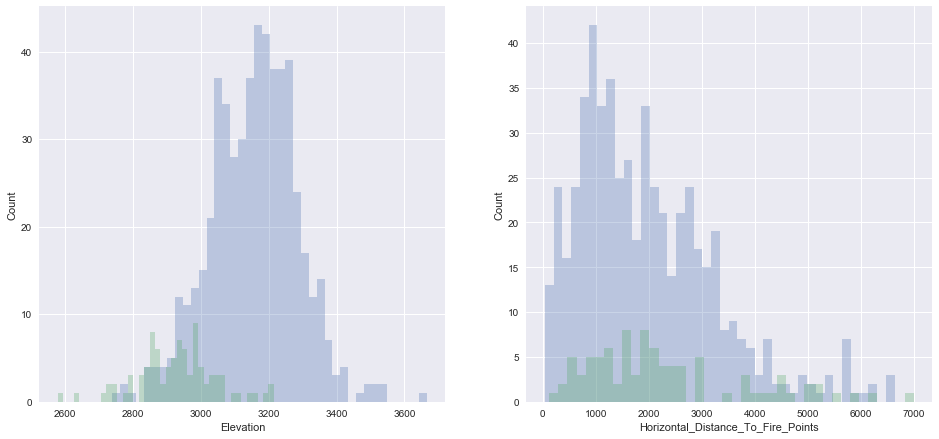

In [54]:
plt.figure(figsize=(16,16)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median elevations: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Elevation), np.median(X_errors.Elevation), (np.median(X_errors.Elevation)/ np.median(X_true.Elevation) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Elevation") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")
plt.show()

### Cover Type 2 Errors

In [55]:
# look at errors with cover type 2 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 2) & (y_test == 2)
X_errors = X_errors[error_msk]

In [56]:
# Describe the accurate predictions
true_msk = (y_pred == 2) & (y_test == 2)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   524.000000  524.000000  524.000000                        524.000000   
mean   2905.083969  145.811069   13.412214                        307.900763   
std     162.187439  106.090299    7.053871                        226.199927   
min    2512.000000    0.000000    1.000000                          0.000000   
25%    2796.750000   54.000000    8.000000                        150.000000   
50%    2919.500000  124.000000   13.000000                        258.000000   
75%    3004.000000  221.000000   17.000000                        430.000000   
max    3387.000000  357.000000   40.000000                       1127.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      524.000000                       524.000000   
mean                        48.589695                      2409.952290   
std                         61.086573                      1593.573116   
min                        -89.000000                        95.000000   
25%                          9.000000                      1119.000000   
50%                         32.000000                      2051.000000   
75%                         70.250000                      3276.750000   
max                        554.000000                      6890.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     524.000000      524.000000     524.000000   
mean      214.103053      225.139313     142.690840   
std        25.319618       17.629002      33.428326   
min        95.000000      141.000000      21.000000   
25%       204.000000      214.000000     120.000000   
50%       220.000000      227.000000     141.000000   
75%       231.000000      239.000000     162.000000   
max       253.000000      254.000000     248.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          524.000000        524.000000        524.000000   
mean                          2275.753817          0.580153          0.013359   
std                           1435.166312          0.494005          0.114915   
min                             95.000000          0.000000          0.000000   
25%                           1253.000000          0.000000          0.000000   
50%                           1950.500000          1.000000          0.000000   
75%                           2716.500000          1.000000          0.000000   
max                           6723.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         524.00000        524.000000       524.0       524.0  524.000000   
mean            0.40458          0.001908         0.0         0.0    0.005725   
std             0.49128          0.043685         0.0         0.0    0.075520   
min             0.00000          0.000000         0.0         0.0    0.000000   
25%             0.00000          0.000000         0.0         0.0    0.000000   
50%             0.00000          0.000000         0.0         0.0    0.000000   
75%             1.00000          0.000000         0.0         0.0    0.000000   
max             1.00000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  524.000000       524.0  524.000000       524.0       524.0  524.000000   
mean     0.007634         0.0    0.001908         0.0         0.0    0.003817   
std      0.087119         0.0    0.043685         0.0         0.0    0.061721   
min      0.000000         0.0    0.000000         0.0         0.0    0.000000   
25%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
50%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
75%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
max      1.000000

In [57]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   198.000000  198.000000  198.000000                        198.000000   
mean   2964.353535  152.000000   14.232323                        240.888889   
std     232.513514  104.232316    7.163540                        178.554739   
min    2353.000000    0.000000    0.000000                          0.000000   
25%    2770.750000   66.000000    9.000000                         95.000000   
50%    3035.000000  132.000000   13.000000                        212.000000   
75%    3145.000000  223.500000   19.000000                        333.750000   
max    3402.000000  358.000000   35.000000                        792.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      198.000000                       198.000000   
mean                        40.237374                      2193.878788   
std                         54.943064                      1533.384874   
min                       -146.000000                        30.000000   
25%                          4.000000                      1090.000000   
50%                         25.500000                      1742.000000   
75%                         60.000000                      3188.250000   
max                        262.000000                      5803.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     198.000000      198.000000     198.000000   
mean      216.474747      224.964646     138.954545   
std        23.921548       18.605271      36.891293   
min       142.000000      165.000000      19.000000   
25%       203.000000      215.250000     116.000000   
50%       223.000000      228.000000     136.500000   
75%       234.750000      238.000000     166.750000   
max       253.000000      254.000000     224.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          198.000000        198.000000        198.000000   
mean                          1732.287879          0.373737          0.075758   
std                           1101.174672          0.485022          0.265281   
min                             42.000000          0.000000          0.000000   
25%                           1067.500000          0.000000          0.000000   
50%                           1571.000000          0.000000          0.000000   
75%                           2199.750000          1.000000          0.000000   
max                           6368.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        198.000000        198.000000       198.0       198.0  198.000000   
mean           0.535354          0.015152         0.0         0.0    0.015152   
std            0.500013          0.122465         0.0         0.0    0.122465   
min            0.000000          0.000000         0.0         0.0    0.000000   
25%            0.000000          0.000000         0.0         0.0    0.000000   
50%            1.000000          0.000000         0.0         0.0    0.000000   
75%            1.000000          0.000000         0.0         0.0    0.000000   
max            1.000000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  198.000000       198.0  198.000000       198.0       198.0       198.0   
mean     0.040404         0.0    0.010101         0.0         0.0         0.0   
std      0.197404         0.0    0.100248         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000

### Cover Type 2 Predicted 1 Errors

In [58]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 1) & (y_test == 2)
X_errors = X_errors[error_msk]

In [59]:
# Describe the accurate predictions
true_msk = (y_pred == 2) & (y_test == 2)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   524.000000  524.000000  524.000000                        524.000000   
mean   2905.083969  145.811069   13.412214                        307.900763   
std     162.187439  106.090299    7.053871                        226.199927   
min    2512.000000    0.000000    1.000000                          0.000000   
25%    2796.750000   54.000000    8.000000                        150.000000   
50%    2919.500000  124.000000   13.000000                        258.000000   
75%    3004.000000  221.000000   17.000000                        430.000000   
max    3387.000000  357.000000   40.000000                       1127.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      524.000000                       524.000000   
mean                        48.589695                      2409.952290   
std                         61.086573                      1593.573116   
min                        -89.000000                        95.000000   
25%                          9.000000                      1119.000000   
50%                         32.000000                      2051.000000   
75%                         70.250000                      3276.750000   
max                        554.000000                      6890.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     524.000000      524.000000     524.000000   
mean      214.103053      225.139313     142.690840   
std        25.319618       17.629002      33.428326   
min        95.000000      141.000000      21.000000   
25%       204.000000      214.000000     120.000000   
50%       220.000000      227.000000     141.000000   
75%       231.000000      239.000000     162.000000   
max       253.000000      254.000000     248.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          524.000000        524.000000        524.000000   
mean                          2275.753817          0.580153          0.013359   
std                           1435.166312          0.494005          0.114915   
min                             95.000000          0.000000          0.000000   
25%                           1253.000000          0.000000          0.000000   
50%                           1950.500000          1.000000          0.000000   
75%                           2716.500000          1.000000          0.000000   
max                           6723.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         524.00000        524.000000       524.0       524.0  524.000000   
mean            0.40458          0.001908         0.0         0.0    0.005725   
std             0.49128          0.043685         0.0         0.0    0.075520   
min             0.00000          0.000000         0.0         0.0    0.000000   
25%             0.00000          0.000000         0.0         0.0    0.000000   
50%             0.00000          0.000000         0.0         0.0    0.000000   
75%             1.00000          0.000000         0.0         0.0    0.000000   
max             1.00000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  524.000000       524.0  524.000000       524.0       524.0  524.000000   
mean     0.007634         0.0    0.001908         0.0         0.0    0.003817   
std      0.087119         0.0    0.043685         0.0         0.0    0.061721   
min      0.000000         0.0    0.000000         0.0         0.0    0.000000   
25%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
50%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
75%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
max      1.000000

In [60]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   118.000000  118.000000  118.000000                        118.000000   
mean   3116.813559  160.618644   13.483051                        258.220339   
std     107.557573  104.961118    6.371321                        180.814923   
min    2785.000000    2.000000    1.000000                          0.000000   
25%    3048.250000   77.500000    9.000000                        120.000000   
50%    3112.500000  131.000000   12.000000                        228.000000   
75%    3187.000000  238.250000   17.000000                        366.000000   
max    3402.000000  358.000000   34.000000                        722.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      118.000000                       118.000000   
mean                        34.601695                      2710.305085   
std                         52.414870                      1651.157571   
min                       -146.000000                       108.000000   
25%                          3.000000                      1259.250000   
50%                         24.000000                      2334.500000   
75%                         51.750000                      3857.750000   
max                        262.000000                      5803.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     118.000000      118.000000     118.000000   
mean      217.415254      225.745763     139.440678   
std        24.212848       17.316652      34.822515   
min       150.000000      165.000000      60.000000   
25%       203.500000      217.250000     116.750000   
50%       224.000000      227.500000     136.000000   
75%       235.000000      237.000000     167.750000   
max       251.000000      254.000000     220.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          118.000000        118.000000        118.000000   
mean                          1855.745763          0.500000          0.118644   
std                           1245.249751          0.502132          0.324748   
min                             42.000000          0.000000          0.000000   
25%                           1106.000000          0.000000          0.000000   
50%                           1685.500000          0.500000          0.000000   
75%                           2299.250000          1.000000          0.000000   
max                           6368.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        118.000000             118.0       118.0       118.0       118.0   
mean           0.381356               0.0         0.0         0.0         0.0   
std            0.487791               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       118.0       118.0       118.0       118.0       118.0       118.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0

Median elevations: True: 2919.500000, Error: 3112.500000, (106.610721%)
Median distance to fire: True: 1950.500000, Error: 1685.500000, (86.413740%)


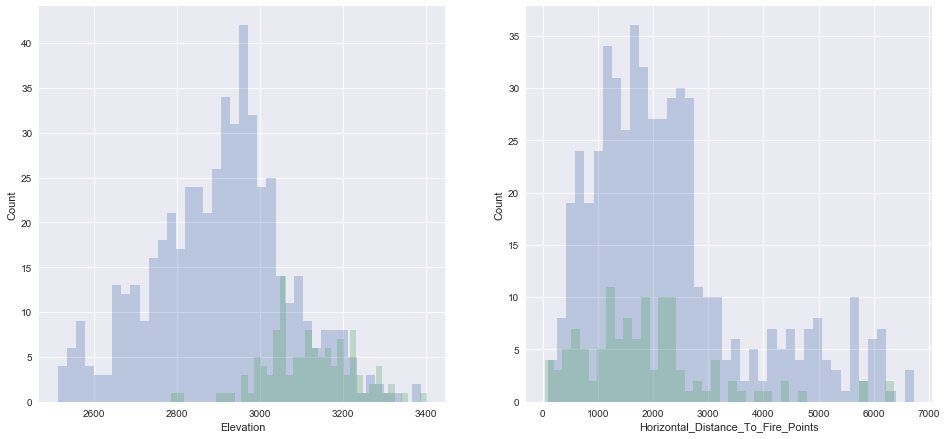

In [61]:
plt.figure(figsize=(16,16)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median elevations: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Elevation), np.median(X_errors.Elevation), (np.median(X_errors.Elevation)/ np.median(X_true.Elevation) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Elevation") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")
plt.show()

We see that this relationship between 1 & 2 with respect to fire is reciprocal in that the numbers are roughly flipped now that we're looking at 2s that were thought to be 1s.

### Cover Type 3 and 6 Errors

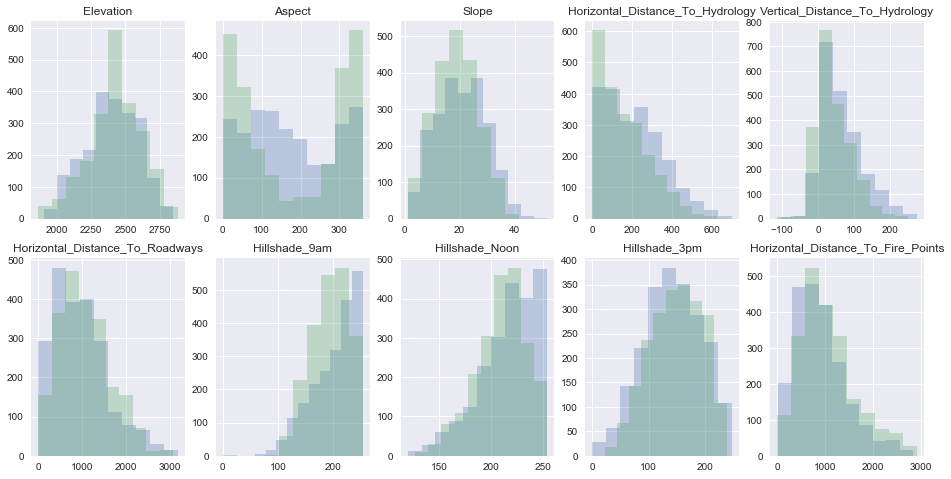

In [62]:
#Display the data between classes 3 and 6
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [3, 6]:
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

These aren't terribly better than 1 & 2. Let's dive deeper and see if anything stands out.

### Cover Type 3 Errors

In [63]:
# look at errors with cover type 2 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 3) & (y_test == 3)
X_errors = X_errors[error_msk]

In [64]:
# Describe the accurate predictions
true_msk = (y_pred == 3) & (y_test == 3)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   615.000000  615.000000  615.000000                        615.000000   
mean   2385.521951  170.373984   21.178862                        211.360976   
std     198.150008  104.986737    8.905798                        138.782537   
min    1905.000000    0.000000    1.000000                          0.000000   
25%    2256.000000   89.000000   14.000000                         95.000000   
50%    2402.000000  154.000000   21.000000                        190.000000   
75%    2540.000000  262.000000   28.000000                        301.000000   
max    2823.000000  360.000000   44.000000                        700.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      615.000000                       615.000000   
mean                        65.826016                       926.965854   
std                         58.831322                       618.260013   
min                       -115.000000                        30.000000   
25%                         23.000000                       419.000000   
50%                         54.000000                       866.000000   
75%                         96.000000                      1299.000000   
max                        275.000000                      3164.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     615.000000      615.000000     615.000000   
mean      203.232520      215.827642     138.003252   
std        41.352929       28.374121      52.912256   
min        65.000000      133.000000       0.000000   
25%       173.500000      199.500000     102.000000   
50%       216.000000      222.000000     136.000000   
75%       237.000000      238.000000     178.000000   
max       254.000000      254.000000     247.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          615.000000             615.0             615.0   
mean                           892.876423               0.0               0.0   
std                            534.385072               0.0               0.0   
min                             30.000000               0.0               0.0   
25%                            486.500000               0.0               0.0   
50%                            819.000000               0.0               0.0   
75%                           1173.000000               0.0               0.0   
max                           2846.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        615.000000        615.000000  615.000000  615.000000  615.000000   
mean           0.385366          0.614634    0.069919    0.121951    0.060163   
std            0.487078          0.487078    0.255218    0.327496    0.237981   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  615.000000  615.000000  615.000000       615.0       615.0       615.0   
mean     0.243902    0.027642    0.107317         0.0         0.0         0.0   
std      0.429784    0.164079    0.309768         0.0         0.0         0.0   
min      0.000000    0.000000    0.000000         0.0         0.0         0.0   
25%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
50%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
75%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
max      1.000000

In [65]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    89.000000   89.000000  89.000000                         89.000000   
mean   2413.516854  174.505618  16.258427                        140.247191   
std     203.472810  117.737103   7.857434                        131.192544   
min    1944.000000    2.000000   1.000000                          0.000000   
25%    2273.000000   67.000000   9.000000                         30.000000   
50%    2409.000000  146.000000  15.000000                         95.000000   
75%    2564.000000  291.000000  22.000000                        192.000000   
max    2806.000000  357.000000  31.000000                        474.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       89.000000                        89.000000   
mean                        26.348315                      1146.528090   
std                         36.601075                       570.611655   
min                        -30.000000                        30.000000   
25%                          3.000000                       765.000000   
50%                         14.000000                      1130.000000   
75%                         40.000000                      1451.000000   
max                        161.000000                      2841.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      89.000000       89.000000      89.000000   
mean      205.977528      219.056180     144.011236   
std        30.841964       22.556172      40.453535   
min       124.000000      162.000000      39.000000   
25%       189.000000      201.000000     108.000000   
50%       211.000000      222.000000     145.000000   
75%       229.000000      235.000000     178.000000   
max       251.000000      254.000000     215.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           89.000000              89.0              89.0   
mean                          1073.303371               0.0               0.0   
std                            546.913621               0.0               0.0   
min                            120.000000               0.0               0.0   
25%                            680.000000               0.0               0.0   
50%                           1050.000000               0.0               0.0   
75%                           1299.000000               0.0               0.0   
max                           2525.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         89.000000         89.000000   89.000000   89.000000   89.000000   
mean           0.438202          0.561798    0.044944    0.089888    0.056180   
std            0.498978          0.498978    0.208355    0.287641    0.231573   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count   89.000000        89.0   89.000000        89.0        89.0        89.0   
mean     0.067416         0.0    0.134831         0.0         0.0         0.0   
std      0.252161         0.0    0.343479         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000         

### Cover Type 3 Predicted 6 Errors

In [66]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 6) & (y_test == 3)
X_errors = X_errors[error_msk]

In [67]:
# Describe the accurate predictions
true_msk = (y_pred == 3) & (y_test == 3)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   615.000000  615.000000  615.000000                        615.000000   
mean   2385.521951  170.373984   21.178862                        211.360976   
std     198.150008  104.986737    8.905798                        138.782537   
min    1905.000000    0.000000    1.000000                          0.000000   
25%    2256.000000   89.000000   14.000000                         95.000000   
50%    2402.000000  154.000000   21.000000                        190.000000   
75%    2540.000000  262.000000   28.000000                        301.000000   
max    2823.000000  360.000000   44.000000                        700.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      615.000000                       615.000000   
mean                        65.826016                       926.965854   
std                         58.831322                       618.260013   
min                       -115.000000                        30.000000   
25%                         23.000000                       419.000000   
50%                         54.000000                       866.000000   
75%                         96.000000                      1299.000000   
max                        275.000000                      3164.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     615.000000      615.000000     615.000000   
mean      203.232520      215.827642     138.003252   
std        41.352929       28.374121      52.912256   
min        65.000000      133.000000       0.000000   
25%       173.500000      199.500000     102.000000   
50%       216.000000      222.000000     136.000000   
75%       237.000000      238.000000     178.000000   
max       254.000000      254.000000     247.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          615.000000             615.0             615.0   
mean                           892.876423               0.0               0.0   
std                            534.385072               0.0               0.0   
min                             30.000000               0.0               0.0   
25%                            486.500000               0.0               0.0   
50%                            819.000000               0.0               0.0   
75%                           1173.000000               0.0               0.0   
max                           2846.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        615.000000        615.000000  615.000000  615.000000  615.000000   
mean           0.385366          0.614634    0.069919    0.121951    0.060163   
std            0.487078          0.487078    0.255218    0.327496    0.237981   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  615.000000  615.000000  615.000000       615.0       615.0       615.0   
mean     0.243902    0.027642    0.107317         0.0         0.0         0.0   
std      0.429784    0.164079    0.309768         0.0         0.0         0.0   
min      0.000000    0.000000    0.000000         0.0         0.0         0.0   
25%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
50%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
75%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
max      1.000000

In [68]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    59.000000   59.000000  59.000000                         59.000000   
mean   2441.169492  177.016949  16.508475                        146.881356   
std     153.157475  124.001320   7.944577                        118.811367   
min    2098.000000    2.000000   1.000000                          0.000000   
25%    2360.000000   56.500000   9.500000                         51.000000   
50%    2443.000000  172.000000  15.000000                        124.000000   
75%    2555.500000  303.500000  22.500000                        192.000000   
max    2739.000000  354.000000  31.000000                        450.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       59.000000                        59.000000   
mean                        29.118644                      1119.610169   
std                         37.487508                       509.276431   
min                        -30.000000                       134.000000   
25%                          4.500000                       801.500000   
50%                         20.000000                      1114.000000   
75%                         41.000000                      1382.000000   
max                        151.000000                      2197.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      59.000000       59.000000      59.000000   
mean      199.152542      216.474576     149.610169   
std        30.840420       24.076284      38.452845   
min       124.000000      162.000000      76.000000   
25%       185.000000      193.500000     123.500000   
50%       202.000000      222.000000     152.000000   
75%       223.500000      237.000000     179.500000   
max       246.000000      252.000000     215.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           59.000000              59.0              59.0   
mean                          1124.423729               0.0               0.0   
std                            488.363566               0.0               0.0   
min                            350.000000               0.0               0.0   
25%                            751.000000               0.0               0.0   
50%                           1114.000000               0.0               0.0   
75%                           1294.500000               0.0               0.0   
max                           2525.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         59.000000         59.000000   59.000000   59.000000   59.000000   
mean           0.491525          0.508475    0.033898    0.067797    0.033898   
std            0.504219          0.504219    0.182521    0.253555    0.182521   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count   59.000000        59.0   59.000000        59.0        59.0        59.0   
mean     0.050847         0.0    0.118644         0.0         0.0         0.0   
std      0.221572         0.0    0.326145         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000         

Median slope: True: 21.000000, Error: 15.000000, (71.428571%)
Median distance to fire: True: 819.000000, Error: 1114.000000, (136.019536%)
Median horizontal_hydro: True: 190.000000, Error: 124.000000, (65.263158%)


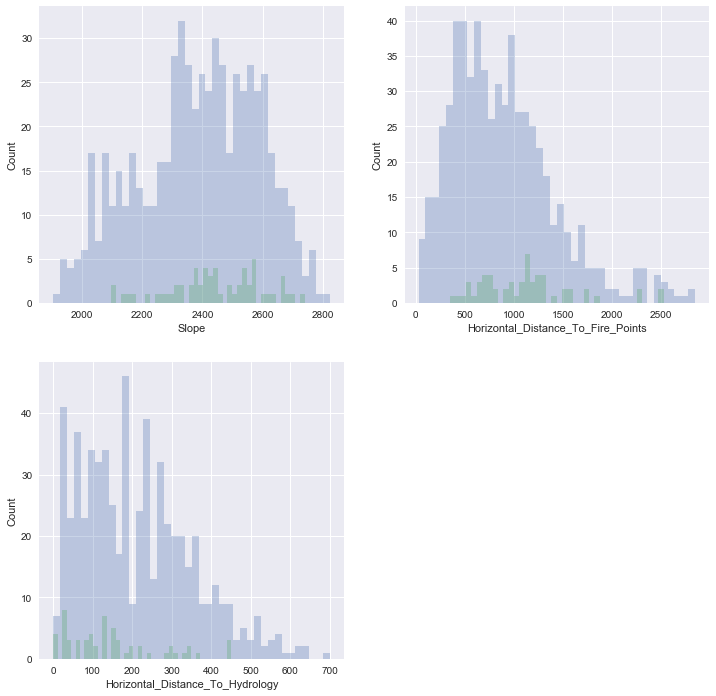

In [69]:
plt.figure(figsize=(12,12)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median slope: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Slope), np.median(X_errors.Slope), (np.median(X_errors.Slope)/ np.median(X_true.Slope) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))
print("Median horizontal_hydro: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Hydrology), np.median(X_errors.Horizontal_Distance_To_Hydrology), (np.median(X_errors.Horizontal_Distance_To_Hydrology)/ np.median(X_true.Horizontal_Distance_To_Hydrology) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Slope") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")

plt.subplot(223)
plt.hist(X_true.Horizontal_Distance_To_Hydrology, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Hydrology, **kwargs);
plt.xlabel("Horizontal_Distance_To_Hydrology") 
plt.ylabel("Count")
plt.show()

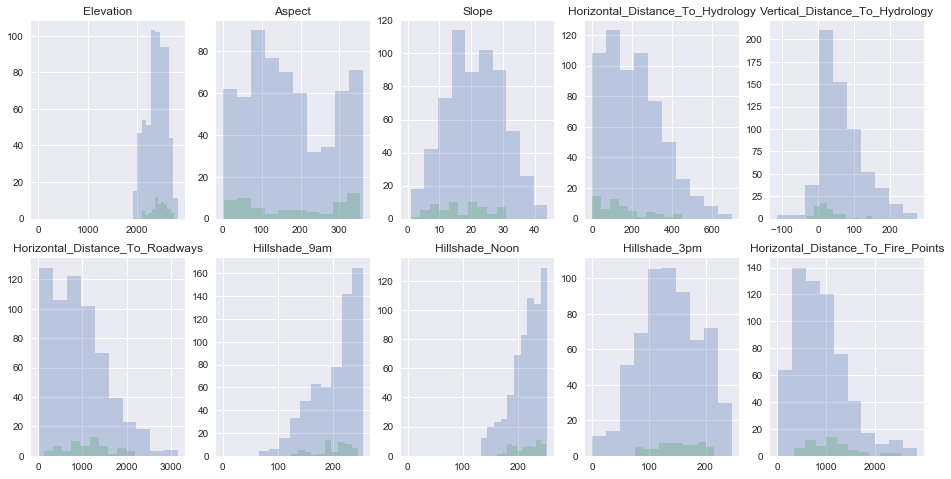

In [70]:
#Display the data between classes 3 and 6
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [3, 6]:
        axi.hist(X_true.ix[labels==label, i], **kwargs)
        axi.hist(X_errors.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

This error certainly seems to have more noticeable differences between the correctly chosen answers and the wrong ones; however with such a relatively small group of errors, it's hard to make any conclusive statements about it.

# Test results

## Default Random Forest Classifier

In [37]:
test_df = pd.read_csv("../data/test.csv")
print(test_df.shape)
test_df.head()

(565892, 55)


Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            196             214            156   
1            201             216            152   
2            206             208            137   
3            208             201            125   
4            210             195            115   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6645                 1                 0   
1                                6675                 1                 0   
2                                6344                 1                 0   
3                                6374                 1                 0   
4                                6404                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0

In [38]:
rfc = RandomForestClassifier()
rfc.fit(data, labels)

test_df['Cover_Type'] = pd.Series(rfc.predict(test_df.drop(['Id'], axis=1)))

submission = pd.concat([test_df['Id'].astype(int), test_df['Cover_Type']], axis=1)
submission = submission.set_index('Id')
submission.to_csv('rfc_default_submission.csv')
submission.head()

Cover_Type
Id               
15121           2
15122           2
15123           2
15124           2
15125           2

Kaggle Results: 0.71859

## Random Forest Classifier with parameter tuning

In [39]:
test_df = pd.read_csv("../data/test.csv")
print(test_df.shape)
test_df.head()

(565892, 55)


Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            196             214            156   
1            201             216            152   
2            206             208            137   
3            208             201            125   
4            210             195            115   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6645                 1                 0   
1                                6675                 1                 0   
2                                6344                 1                 0   
3                                6374                 1                 0   
4                                6404                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0

In [40]:
rfc = RandomForestClassifier(max_features='sqrt', n_estimators=1000,
                             max_depth=35, bootstrap=False, criterion='entropy', n_jobs=-1)
# Had to choose different features that worked earlier that don't match 
# the best of what grid search found because of dead kernel issues
rfc.fit(data, labels)

test_df['Cover_Type'] = pd.Series(rfc.predict(test_df.drop(['Id'], axis=1)))

submission = pd.concat([test_df['Id'].astype(int), test_df['Cover_Type']], axis=1)
submission = submission.set_index('Id')
submission.to_csv('rfc_tuned_submission.csv')
submission.head()

Cover_Type
Id               
15121           2
15122           1
15123           2
15124           2
15125           2

Kaggle results: 0.77288

With parameter tuning we can improve the prediction rate by about 6%.

## Random Forest Classifier with parameter tuning and feature engineering

In [41]:
test_df = pd.read_csv("../data/test.csv")
print(test_df.shape)
test_df.head()

(565892, 55)


Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            196             214            156   
1            201             216            152   
2            206             208            137   
3            208             201            125   
4            210             195            115   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6645                 1                 0   
1                                6675                 1                 0   
2                                6344                 1                 0   
3                                6374                 1                 0   
4                                6404                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0

In [42]:
# ### Add new features to test data and training data
new_train = get_new_features_data_rf(data)
new_test_df = get_new_features_data_rf(test_df)
new_test_df.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            196             214            156   
1            201             216            152   
2            206             208            137   
3            208             201            125   
4            210             195            115   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6645                 1                 0   
1                                6675                 1                 0   
2                                6344                 1                 0   
3                                6374                 1                 0   
4                                6404                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0

In [43]:
#rfc = best_rfc.get_params()['randomforestclassifier']
rfc = RandomForestClassifier(max_features='sqrt', n_estimators=1000,
                             max_depth=35, bootstrap=False, criterion='entropy', n_jobs=-1)
# Had to choose different features that worked earlier that don't match 
# the best of what grid search found because of dead kernel issues

rfc.fit(new_train, labels)

new_test_df['Cover_Type'] = pd.Series(rfc.predict(new_test_df.drop(['Id'], axis=1)))

submission = pd.concat([new_test_df['Id'].astype(int), new_test_df['Cover_Type']], axis=1)
submission = submission.set_index('Id')
submission.to_csv('submission.csv')
submission.head()

Cover_Type
Id               
15121           1
15122           1
15123           1
15124           1
15125           1

Results from Kaggle: 0.80535

![kaggle](kaggle_screenshot.png)

Using feature engineering and parameter tuning we were able to improve the results by about 3%.

# Appendix
a. There being so many soil types, we thought that it might be advantageous to utilze PCA to reduce the variables needed.

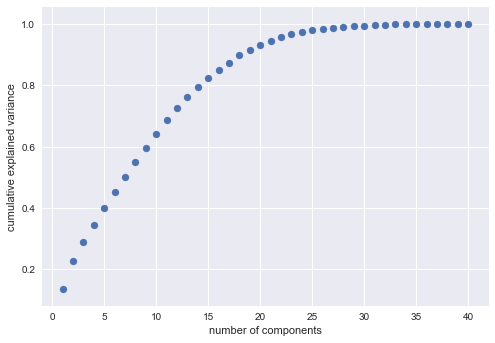

In [74]:
# Separate soil data from X_train

X_train_less_soil = X_train.drop([i for i in X_train.columns if "Soil_Type" in i],axis=1)
X_test_less_soil = X_test.drop([i for i in X_test.columns if "Soil_Type" in i],axis=1)

soil_train = X_train[[i for i in X_train.columns if "Soil_Type" in i]]
soil_test = X_test[[i for i in X_test.columns if "Soil_Type" in i]]

pca = PCA(n_components=40)
pca.fit(soil_train)
plt.scatter(range(1,41),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

**We see that with only 15 components that we preserve about 80% of the variation.**

In [75]:
# Fit PCA and transform train and test data
p = PCA(n_components=15)
pca_soil_train = p.fit_transform(soil_train)
pca_soil_test = p.transform(soil_test)

# Convert back to Dataframes
pca_soil_train = pd.DataFrame(pca_soil_train)
pca_soil_test = pd.DataFrame(pca_soil_test)

# Make sure they're still on same index
pca_soil_train.index = soil_train.index
pca_soil_test.index = soil_test.index

# Put data back together
soil_pca_X_train = pd.concat([X_train_less_soil,pca_soil_train],axis=1,join_axes=[X_train_less_soil.index])
soil_pca_X_test = pd.concat([X_test_less_soil,pca_soil_test],axis=1,join_axes=[X_test_less_soil.index])

RF = RandomForestClassifier()

RF.fit(X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(X_test, y_test)))

RF.fit(soil_pca_X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(soil_pca_X_test, y_test)))

The accuracy score before PCA reduction was: 0.8589178356713427
The accuracy score before PCA reduction was: 0.864128256513026


## Features that didn't work

Features that we thought would be helpful to engineer.  However, by engineering these features, we didn't see much improvement and therefore these were discarded in the final model.

### Binning hillshade_9am

In [76]:
def bin_hillshade_9am_feat(data):
    new_data = data.copy(deep=True)

    noon_bins = np.linspace(0, 255, 8)
    which_bin = np.digitize(new_data.Hillshade_9am, bins=noon_bins)
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(which_bin.reshape(-1, 1))
    X_noon_binned = pd.DataFrame(encoder.transform(which_bin.reshape(-1, 1)))

    new_data = pd.concat([new_data, X_noon_binned], axis=1)

    return new_data

In [77]:
new_data = bin_hillshade_9am_feat(data)
print_base_results(new_data)

Base RFC: 0.8184, New RFC: 0.8166
Base LR:  0.6772, New LR:  0.6772


### Euclidean Distance to Hydrology

In [78]:
def new_euclidean_hydro(data):
    new_data = data.copy(deep=True)
    new_feature = (new_data.Horizontal_Distance_To_Hydrology**2 + new_data.Vertical_Distance_To_Hydrology**2) ** (1/2)
    new_data['new_euclidean_hydro'] = new_feature
    return new_data

new_data = new_euclidean_hydro(data)
print_base_results(new_data)

Base RFC: 0.8184, New RFC: 0.8226
Base LR:  0.6772, New LR:  0.6770


### Slope using Elevation and Hydrology

In [79]:
#Adjusting distance to hydrology and roadways 
slope_train = pd.DataFrame()
slope_test = pd.DataFrame()

#Elevation adjusted by Horizontal distance to Hyrdrology 
slope_train['slope_hyd'] = np.sqrt(X_train.Vertical_Distance_To_Hydrology**2 + X_train.Horizontal_Distance_To_Hydrology**2) 
slope_train.slope_hyd=slope_train.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_train['slope_hyd_pct'] = X_train.Vertical_Distance_To_Hydrology / X_train.Horizontal_Distance_To_Hydrology
slope_train.slope_hyd_pct=slope_train.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_test['slope_hyd'] = np.sqrt(X_test.Vertical_Distance_To_Hydrology**2 + X_test.Horizontal_Distance_To_Hydrology**2) 
slope_test.slope_hyd=slope_test.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_test['slope_hyd_pct'] = X_test.Vertical_Distance_To_Hydrology / X_test.Horizontal_Distance_To_Hydrology
slope_test.slope_hyd_pct=slope_test.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_train.index = X_train.index
slope_test.index = X_test.index

X_train_slope = pd.concat([X_train,slope_train], axis =1, join_axes=[X_train.index])
X_test_slope = pd.concat([X_test,slope_test], axis=1, join_axes=[X_test.index])

# Test on a model

without_slope = []
with_slope = []
for i in range(10):
    log = RandomForestClassifier()
    log.fit(X_train, y_train)
    without_slope.append(log.score(X_test, y_test))

    log.fit(X_train_slope, y_train)
    with_slope.append(log.score(X_test_slope, y_test))
print ("Accuracy without extra slope feature is {}".format(np.mean(without_slope)))
print ("Accuracy with extra slope feature is {}".format(np.mean(with_slope)))

Accuracy without extra slope feature is 0.8539278557114228
Accuracy with extra slope feature is 0.8516833667334669


### Convert aspect to cardinal direction (north, south, east, west)

In [80]:
def convert_to_cardinal_feat(data):
    new_data = data.copy(deep=True)
    dir_labels = ['north east', 'east north', 'east south', 'south east', 
              'south west', 'west south', 'west north', 'north west']
    new_data.loc[:, ('direction')] = pd.cut(data.loc[:, ('Aspect')], range(0, 365, 45), right=False, labels=dir_labels)

    new_data.direction = new_data.direction.replace('east north', 'north') \
        .replace('north west', 'north') \
        .replace('east north', 'east').replace('east south', 'east').replace('south east', 'south') \
        .replace('south west', 'south').replace('west south', 'west').replace('west north', 'west') \
        .replace('north east', 'north')

    new_data = pd.get_dummies(new_data)
    return new_data

In [81]:
new_data = convert_to_cardinal_feat(data)
print_base_results(new_data)

Base RFC: 0.8184, New RFC: 0.8168
Base LR:  0.6772, New LR:  0.6794
